In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import os
import sys
import pandas as pd
import copy
import scipy
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD
import argparse
import torch.nn as nn
import torch
import importlib
import argparse
from sklearn.metrics import confusion_matrix, roc_curve
from scipy import interp
from sklearn.calibration import calibration_curve
import geopandas as gpd
from shapely.ops import unary_union, polygonize
from shapely.geometry import Polygon, MultiPolygon
from sklearn.metrics import roc_auc_score
import random
import glob
from sklearn import preprocessing
from sklearn.metrics.pairwise import euclidean_distances
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from matplotlib.image import imread
import matplotlib.gridspec as gridspec
from matplotlib.transforms import Bbox
import matplotlib as mpl
from numpy.linalg import inv
from numpy.linalg import norm
from sklearn.datasets import make_regression
from scipy.interpolate import CubicSpline
import librosa
import matplotlib.image as mpimg
from scipy.interpolate import splprep, splev
from tsp_solver.greedy import solve_tsp
from scipy.spatial.distance import pdist, squareform
from python_tsp.heuristics import solve_tsp_simulated_annealing
import math
from scipy.ndimage import gaussian_filter1d
from PIL import Image, ImageEnhance, ImageFilter
import cv2 
from matplotlib import patches

ROOT = '' # set
sys.path.append(ROOT)

import utils

# change the width of the cells
from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

# activate LaTeX font and define fontsize
plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{amsmath}')
plt.rc('font', size=11)

/home/davidsusic/miniconda3/envs/ds_env/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Define paths

In [5]:
DATA = utils.check_folder(os.path.join(ROOT, 'data'))
EXPERIMENTS = utils.check_folder(os.path.join(ROOT, 'experiments'))
RESULTS = utils.check_folder(os.path.join(ROOT, 'results'))

### Main Peformance Table

In [6]:
def propagate_error(a, da, b, db):
    re_a = (da/a)**2
    re_b = (db/b)**2
    re = np.sqrt(re_a+re_b) # this is (dc/c)
    return re

def relative_improv_over_vanilla(accuracy_df, std_df, n_fracs=[0.015, 0.052, 0.1, 0.2, 0.3, 0.4, 0.6, 0.8, 1.0]):
    n_fracs = [str(x) for x in n_fracs]
    ri_mean = copy.deepcopy(accuracy_df)
    ri_mean.loc[:, n_fracs]=np.nan
    ri_std = copy.deepcopy(accuracy_df)
    ri_std.loc[:, n_fracs]=np.nan
    for i in range(len(ri_mean)):
        if i==0: continue
        for n_frac in n_fracs:
            # vanilla
            b = accuracy_df.loc[0,n_frac]
            db = std_df.loc[0,n_frac]
            # method
            a = accuracy_df.loc[i,n_frac]
            da = std_df.loc[i,n_frac]
            re = propagate_error(a, da, b, db)
            #ri_df.loc[i,n_frac] = f'_{np.round((a/b-1)*100, 2)}\ pm{np.round(re*a/b*100, 2)}_'    
            ri_mean.loc[i,n_frac] = np.round((a/b-1)*100, 2)
            ri_std.loc[i,n_frac] = {np.round(re*a/b*100, 2)}
    return ri_mean, ri_std  

custom_order = ['Vanilla', 'NoiseInject', 'TimeMask', 'MagWarp', 'RespScale', 'Mixup', 'ManifoldMixup', 'PCGmix', 'PCGmix+']
# Potes
acc_mean_potes = pd.read_csv(os.path.join(EXPERIMENTS, 'PhysioNet_Potes_all_seeds_Accuracy-mean.csv'))
acc_mean_potes = acc_mean_potes.set_index('Method').loc[custom_order].reset_index()
acc_std_potes = pd.read_csv(os.path.join(EXPERIMENTS, 'PhysioNet_Potes_all_seeds_Accuracy-std.csv'))
acc_std_potes = acc_std_potes.set_index('Method').loc[custom_order].reset_index()
ri_mean_potes, ri_std_potes = relative_improv_over_vanilla(acc_mean_potes, acc_std_potes)
adsi_potes = pd.read_csv(os.path.join(EXPERIMENTS, 'PhysioNet_Potes_all_seeds_adsi.csv'))
adsi_potes = adsi_potes.set_index('Method').loc[custom_order].reset_index()
# resnet9
acc_mean_resnet = pd.read_csv(os.path.join(EXPERIMENTS, 'PhysioNet_resnet9_all_seeds_Accuracy-mean.csv'))
acc_mean_resnet = acc_mean_resnet.set_index('Method').loc[custom_order].reset_index()
acc_std_resnet = pd.read_csv(os.path.join(EXPERIMENTS, 'PhysioNet_resnet9_all_seeds_Accuracy-std.csv'))
acc_std_resnet = acc_std_resnet.set_index('Method').loc[custom_order].reset_index()
ri_mean_resnet, ri_std_resnet = relative_improv_over_vanilla(acc_mean_resnet, acc_std_resnet)
adsi_resnet = pd.read_csv(os.path.join(EXPERIMENTS, 'PhysioNet_resnet9_all_seeds_adsi.csv'))
adsi_resnet = adsi_resnet.set_index('Method').loc[custom_order].reset_index()

# display(acc_mean_potes)
# display(acc_std_potes)
# display(ri_mean_potes)

# Reshape the dataframes
# Potes
acc_mean_potes = pd.melt(acc_mean_potes, id_vars=['Method'], var_name=['N frac'], value_name='Potes acc')[['N frac', 'Method', 'Potes acc']]
acc_std_potes = pd.melt(acc_std_potes, id_vars=['Method'], var_name=['N frac'], value_name='Potes acc sd')[['N frac', 'Method', 'Potes acc sd']]
ri_mean_potes = pd.melt(ri_mean_potes, id_vars=['Method'], var_name=['N frac'], value_name='Potes ri')[['N frac', 'Method', 'Potes ri']]
ri_std_potes = pd.melt(ri_std_potes, id_vars=['Method'], var_name=['N frac'], value_name='Potes ri sd')[['N frac', 'Method', 'Potes ri sd']]
adsi_potes = pd.melt(adsi_potes, id_vars=['Method'], var_name=['N frac'], value_name='Potes adsi')[['N frac', 'Method', 'Potes adsi']]
# resnet9
acc_mean_resnet = pd.melt(acc_mean_resnet, id_vars=['Method'], var_name=['N frac'], value_name='resnet acc')[['N frac', 'Method', 'resnet acc']]
acc_std_resnet = pd.melt(acc_std_resnet, id_vars=['Method'], var_name=['N frac'], value_name='resnet acc sd')[['N frac', 'Method', 'resnet acc sd']]
ri_mean_resnet = pd.melt(ri_mean_resnet, id_vars=['Method'], var_name=['N frac'], value_name='resnet ri')[['N frac', 'Method', 'resnet ri']]
ri_std_resnet = pd.melt(ri_std_resnet, id_vars=['Method'], var_name=['N frac'], value_name='resnet ri sd')[['N frac', 'Method', 'resnet ri sd']]
adsi_resnet = pd.melt(adsi_resnet, id_vars=['Method'], var_name=['N frac'], value_name='resnet adsi')[['N frac', 'Method', 'resnet adsi']]
# concat
dfs = [
    acc_mean_potes,
    acc_std_potes,
    ri_mean_potes,
    ri_std_potes,
    adsi_potes,
    acc_mean_resnet,
    acc_std_resnet,
    ri_mean_resnet,
    ri_std_resnet,
    adsi_resnet
    ]
results_df = pd.concat([dfs[0].iloc[:, :2]] + [df.iloc[:, 2:] for df in dfs], axis=1)
results_df['Potes acc'] =  results_df['Potes acc'].astype(str) + ' _\ pm_ ' + results_df['Potes acc sd'].astype(str) 
results_df['Potes ri'] = results_df['Potes ri'].astype(str) + ' _\ pm_ ' + results_df['Potes ri sd'].astype(str) 
results_df['resnet acc'] =  results_df['resnet acc'].astype(str) + ' _\ pm_ ' + results_df['resnet acc sd'].astype(str) 
results_df['resnet ri'] =  results_df['resnet ri'].astype(str) + ' _\ pm_ ' + results_df['resnet ri sd'].astype(str) 
results_df = results_df[['N frac', 'Method', 'Potes acc', 'Potes ri', 'Potes adsi', 'resnet acc', 'resnet ri', 'resnet adsi']]
# clean it
results_df = results_df.replace({np.nan:'-', 'Vanilla': 'Vanilla (no aug.)', 'PCGmix':'PCGmix (ours)', 'PCGmix+':'PCGmix+ (ours)'})
results_df = results_df.astype(str)
results_df = results_df.replace({'nan _\ pm_ nan':'-'})

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(results_df)

,N frac,Method,Potes acc,Potes ri,Potes adsi,resnet acc,resnet ri,resnet adsi
0,0.015,Vanilla (no aug.),58.63 _\ pm_ 5.8,-,-,56.22 _\ pm_ 5.86,-,-
1,0.015,NoiseInject,58.64 _\ pm_ 5.66,0.02 _\ pm_ 13.82,1.0,56.4 _\ pm_ 5.92,0.32 _\ pm_ 14.84,1.06
2,0.015,TimeMask,58.05 _\ pm_ 5.56,-0.99 _\ pm_ 13.63,-,56.22 _\ pm_ 5.69,0.0 _\ pm_ 14.53,1.0
3,0.015,MagWarp,58.59 _\ pm_ 5.72,-0.07 _\ pm_ 13.89,-,56.35 _\ pm_ 5.91,0.23 _\ pm_ 14.82,1.05
4,0.015,RespScale,58.82 _\ pm_ 5.99,0.32 _\ pm_ 14.24,1.08,56.38 _\ pm_ 6.68,0.28 _\ pm_ 15.83,1.06
5,0.015,Mixup,58.42 _\ pm_ 5.86,-0.36 _\ pm_ 14.04,-,56.69 _\ pm_ 6.2,0.84 _\ pm_ 15.23,1.17
6,0.015,ManifoldMixup,58.35 _\ pm_ 5.75,-0.48 _\ pm_ 13.9,-,56.13 _\ pm_ 6.1,-0.16 _\ pm_ 15.03,-
7,0.015,PCGmix (ours),59.39 _\ pm_ 5.92,1.3 _\ pm_ 14.23,1.31,57.04 _\ pm_ 6.21,1.46 _\ pm_ 15.29,1.29
8,0.015,PCGmix+ (ours),59.49 _\ pm_ 5.95,1.47 _\ pm_ 14.27,1.35,57.49 _\ pm_ 6.07,2.26 _\ pm_ 15.17,1.45
9,0.052,Vanilla (no aug.),64.61 _\ pm_ 4.25,-,-,63.22 _\ pm_ 4.94,-,-


### Accuracy + Relative improvement + ADSI same graph (resnet9)

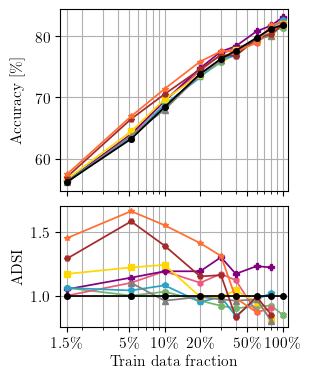

In [35]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('text.latex', preamble=r'\usepackage{amsmath}')
plt.rc('font', size=11)

methods = [
          'base', 
          'gaussiannoise(25,40)',
          'timemask(0.2)',
          'magnitudewarp(0.2,4)',
          #'timewarp(0.05,4)',
          'respiratoryscale(12,20)',
          'mixup(same)',
          'latentmixup',
          'durratiomixup',
          'durmixmagwarp(0.2,4)',
        ]

methods_fmts = ['-o',
                '-X',
                '-h',
                '-P',
                '-p',
                '-s',
                '-^',
                '-H',
                '-*'
               ]

methods_abbrvs = [
            'Vanilla',
            'NoiseInject',
            'TimeMask',
            'MagWarp',
            #'TimeWarp',
            'RespScale',
            'Mixup',
            'ManifoldMixup',
            'PCGmix',
            'PCGmix+',
         ]

methods_colors = [
    'k',
    '#73B66B',
    '#EF597B',
    'purple',
    '#29A2C6',
    'gold',
    'grey',
    'brown',
    '#FF6D31'
]

n_fractions = [0.015, 0.052, 0.1, 0.2, 0.3, 0.4, 0.6, 0.8, 1.0]

lw = 1.25
fac = 0.55
marksize = 4
fig, axes = plt.subplots(2, 1, figsize = (4.6*fac, 7.5*fac), gridspec_kw={'height_ratios': [1.5, 1], 'hspace':0.1})
plt.subplots_adjust(left=0, hspace=0.1, wspace=0.1) 

### Accuracy
#acc_mean_resnet
#ri_mean_resnet
#adsi_resnet
for i, (method, method_abbrv, method_c, method_fmt) in enumerate(zip(methods, methods_abbrvs, methods_colors, methods_fmts)):
    accs_arr = acc_mean_resnet[acc_mean_resnet['Method']==method_abbrv]['resnet acc'].values
    if method_abbrv == 'Vanilla':
        axes[0].plot(n_fractions, accs_arr, method_fmt, color= method_c, linewidth=lw, markersize=marksize, zorder=3)
    else:
        axes[0].plot(n_fractions, accs_arr, method_fmt, color= method_c, linewidth=lw, markersize=marksize)
axes[0].set_ylabel('Accuracy [\%]') 
    

# ADSI improvement graph
for i, (method, method_abbrv, method_c, method_fmt) in enumerate(zip(methods, methods_abbrvs, methods_colors, methods_fmts)):
    adsi_arr = adsi_resnet[adsi_resnet['Method']==method_abbrv]['resnet adsi'].values
    if method_abbrv in ['Vanilla']: 
        axes[1].plot(n_fractions, [1 for i in n_fractions], method_fmt, color= method_c, label=f'{method_abbrv}', markersize=marksize, linewidth=lw, zorder=3)  
        continue
    # plot   
    else:
        axes[1].plot(n_fractions, adsi_arr, method_fmt, color= method_c, label=f'{method_abbrv}', markersize=marksize, linewidth=lw)  
axes[1].set_xlabel('Training-data fraction', fontsize=11)
axes[1].set_ylabel('ADSI', fontsize=11)
#plt.legend(ncol=3, bbox_to_anchor=(0, -1.4), loc="upper left")#, bbox_to_anchor=(1.7,0.5))

for ax in axes:
    ax.set_xscale('log')
    labels = [item.get_text() for item in ax.get_xticklabels()]
    #print(len(labels), labels)
    ax.set_xticks([0.015, 0.05, 0.1, 0.2, 0.5, 1.0])
    #print(len(labels), labels)
    labels = ['1.5\%','5\%', '10\%','20\%', '50\%','100\%']
    ax.set_xticklabels(labels, fontsize=11)
#     major_ticks = np.linspace(0, 1, 11)
#     ax.set_xticks(major_ticks)
    ax.grid(which='both')
    ax.set_xlim(0.013, 1.1)
        

for ax in fig.get_axes():
    ax.label_outer()  
    
fig.align_ylabels(axes)
      
# save legend separately
legend = plt.legend(ncol=3, bbox_to_anchor=(1.02,-0.4), frameon=False, fontsize=11)
fig  = legend.figure
fig.canvas.draw()
bbox  = legend.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
#fig.savefig(filename, dpi="figure", bbox_inches=bbox)
for extension in ['jpg', 'pdf', 'png']:
    FILENAME=os.path.join(RESULTS, f'PhysioNet_acc_ADSI_legend.{extension}')
    fig.savefig(FILENAME, dpi=600, bbox_inches=bbox)  
legend.remove()
    
# save the plot
plt.tight_layout()
for extension in ['jpg', 'pdf', 'png']:
    FILENAME=os.path.join(RESULTS, f'PhysioNet_acc_ADSI_resnet.{extension}')
    plt.savefig(FILENAME, dpi=600, bbox_inches='tight')
plt.show()
plt.close()

For IPS (MPŠ) with added legend:

/tmp/ipykernel_3819674/3891315374.py:118: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


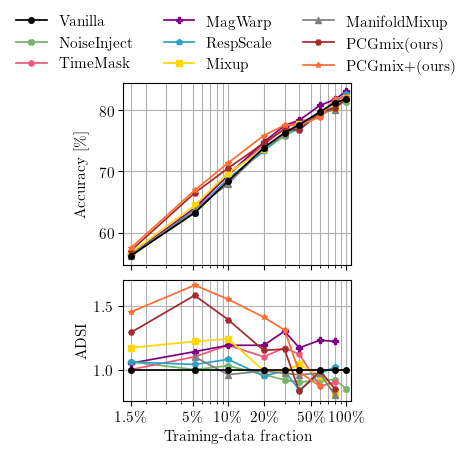

In [9]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('text.latex', preamble=r'\usepackage{amsmath}')
plt.rc('font', size=11)

methods = [
          'base', 
          'gaussiannoise(25,40)',
          'timemask(0.2)',
          'magnitudewarp(0.2,4)',
          #'timewarp(0.05,4)',
          'respiratoryscale(12,20)',
          'mixup(same)',
          'latentmixup',
          'durratiomixup',
          'durmixmagwarp(0.2,4)',
        ]

methods_fmts = ['-o',
                '-X',
                '-h',
                '-P',
                '-p',
                '-s',
                '-^',
                '-H',
                '-*'
               ]

methods_abbrvs = [
            'Vanilla',
            'NoiseInject',
            'TimeMask',
            'MagWarp',
            #'TimeWarp',
            'RespScale',
            'Mixup',
            'ManifoldMixup',
            'PCGmix',
            'PCGmix+',
         ]

methods_colors = [
    'k',
    '#73B66B',
    '#EF597B',
    'purple',
    '#29A2C6',
    'gold',
    'grey',
    'brown',
    '#FF6D31'
]

n_fractions = [0.015, 0.052, 0.1, 0.2, 0.3, 0.4, 0.6, 0.8, 1.0]

lw = 1.25
fac = 0.55
marksize = 4
fig, axes = plt.subplots(2, 1, figsize = (4.6*fac, 7.5*fac), gridspec_kw={'height_ratios': [1.5, 1], 'hspace':0.1})
plt.subplots_adjust(left=0, hspace=0.1, wspace=0.1) 

### Accuracy
#acc_mean_resnet
#ri_mean_resnet
#adsi_resnet
for i, (method, method_abbrv, method_c, method_fmt) in enumerate(zip(methods, methods_abbrvs, methods_colors, methods_fmts)):
    accs_arr = acc_mean_resnet[acc_mean_resnet['Method']==method_abbrv]['resnet acc'].values
    if method_abbrv == 'Vanilla':
        axes[0].plot(n_fractions, accs_arr, method_fmt, color= method_c, linewidth=lw, markersize=marksize, zorder=3)
    else:
        axes[0].plot(n_fractions, accs_arr, method_fmt, color= method_c, linewidth=lw, markersize=marksize)
axes[0].set_ylabel('Accuracy [\%]') 
    

# ADSI improvement graph
for i, (method, method_abbrv, method_c, method_fmt) in enumerate(zip(methods, methods_abbrvs, methods_colors, methods_fmts)):
    adsi_arr = adsi_resnet[adsi_resnet['Method']==method_abbrv]['resnet adsi'].values
    if method_abbrv in ['Vanilla']: 
        axes[1].plot(n_fractions, [1 for i in n_fractions], method_fmt, color= method_c, label=f'{method_abbrv}', markersize=marksize, linewidth=lw, zorder=3)  
        continue
    # plot   
    else:
        axes[1].plot(n_fractions, adsi_arr, method_fmt, color= method_c, label=f'{method_abbrv}', markersize=marksize, linewidth=lw)  
axes[1].set_xlabel('Training-data fraction', fontsize=11)
axes[1].set_ylabel('ADSI', fontsize=11)
#plt.legend(ncol=3, bbox_to_anchor=(0, -1.4), loc="upper left")#, bbox_to_anchor=(1.7,0.5))

for ax in axes:
    ax.set_xscale('log')
    labels = [item.get_text() for item in ax.get_xticklabels()]
    #print(len(labels), labels)
    ax.set_xticks([0.015, 0.05, 0.1, 0.2, 0.5, 1.0])
    #print(len(labels), labels)
    labels = ['1.5\%','5\%', '10\%','20\%', '50\%','100\%']
    ax.set_xticklabels(labels, fontsize=11)
#     major_ticks = np.linspace(0, 1, 11)
#     ax.set_xticks(major_ticks)
    ax.grid(which='both')
    ax.set_xlim(0.013, 1.1)
        

for ax in fig.get_axes():
    ax.label_outer()  
    
fig.align_ylabels(axes)
      
# save legend separately
legend = plt.legend(ncol=3, bbox_to_anchor=(1.52,3.3), frameon=False, fontsize=11)
legend.get_texts()[-2].set_text('PCGmix(ours)')
legend.get_texts()[-1].set_text('PCGmix+(ours)')
fig  = legend.figure
fig.canvas.draw()
bbox  = legend.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
#legend.remove()
    
# save the plot
plt.tight_layout()
for extension in ['jpg', 'pdf', 'png']:
    FILENAME=os.path.join(RESULTS, f'MPS_PhysioNet_acc_ADSI_resnet.{extension}')
    plt.savefig(FILENAME, dpi=600, bbox_inches='tight')
plt.show()
plt.close()

For ARIS application "PREDLOG DOSEŽKA ZA IZBOR ODLIČNI V ZNANOSTI 2025" with added legend:

English

/tmp/ipykernel_3819674/3974379914.py:118: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


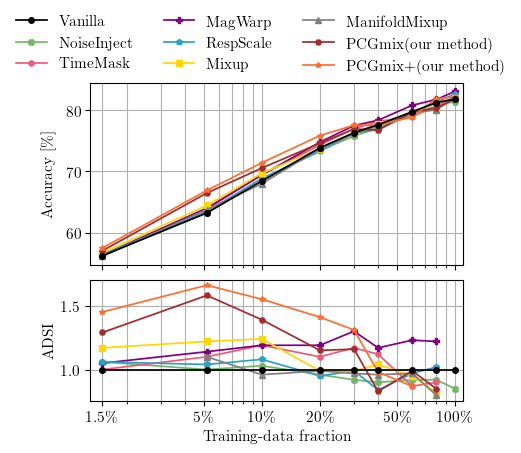

In [24]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('text.latex', preamble=r'\usepackage{amsmath}')
plt.rc('font', size=11)

methods = [
          'base', 
          'gaussiannoise(25,40)',
          'timemask(0.2)',
          'magnitudewarp(0.2,4)',
          #'timewarp(0.05,4)',
          'respiratoryscale(12,20)',
          'mixup(same)',
          'latentmixup',
          'durratiomixup',
          'durmixmagwarp(0.2,4)',
        ]

methods_fmts = ['-o',
                '-X',
                '-h',
                '-P',
                '-p',
                '-s',
                '-^',
                '-H',
                '-*'
               ]

methods_abbrvs = [
            'Vanilla',
            'NoiseInject',
            'TimeMask',
            'MagWarp',
            #'TimeWarp',
            'RespScale',
            'Mixup',
            'ManifoldMixup',
            'PCGmix',
            'PCGmix+',
         ]

methods_colors = [
    'k',
    '#73B66B',
    '#EF597B',
    'purple',
    '#29A2C6',
    'gold',
    'grey',
    'brown',
    '#FF6D31'
]

n_fractions = [0.015, 0.052, 0.1, 0.2, 0.3, 0.4, 0.6, 0.8, 1.0]

lw = 1.25
fac = 0.9
marksize = 4
fig, axes = plt.subplots(2, 1, figsize = (4.6*fac, 4.125), gridspec_kw={'height_ratios': [1.5, 1], 'hspace':0.1})
plt.subplots_adjust(left=0, hspace=0.1, wspace=0.1) 

### Accuracy
#acc_mean_resnet
#ri_mean_resnet
#adsi_resnet
for i, (method, method_abbrv, method_c, method_fmt) in enumerate(zip(methods, methods_abbrvs, methods_colors, methods_fmts)):
    accs_arr = acc_mean_resnet[acc_mean_resnet['Method']==method_abbrv]['resnet acc'].values
    if method_abbrv == 'Vanilla':
        axes[0].plot(n_fractions, accs_arr, method_fmt, color= method_c, linewidth=lw, markersize=marksize, zorder=3)
    else:
        axes[0].plot(n_fractions, accs_arr, method_fmt, color= method_c, linewidth=lw, markersize=marksize)
axes[0].set_ylabel('Accuracy [\%]') 
    

# ADSI improvement graph
for i, (method, method_abbrv, method_c, method_fmt) in enumerate(zip(methods, methods_abbrvs, methods_colors, methods_fmts)):
    adsi_arr = adsi_resnet[adsi_resnet['Method']==method_abbrv]['resnet adsi'].values
    if method_abbrv in ['Vanilla']: 
        axes[1].plot(n_fractions, [1 for i in n_fractions], method_fmt, color= method_c, label=f'{method_abbrv}', markersize=marksize, linewidth=lw, zorder=3)  
        continue
    # plot   
    else:
        axes[1].plot(n_fractions, adsi_arr, method_fmt, color= method_c, label=f'{method_abbrv}', markersize=marksize, linewidth=lw)  
axes[1].set_xlabel('Training-data fraction', fontsize=11)
axes[1].set_ylabel('ADSI', fontsize=11)
#plt.legend(ncol=3, bbox_to_anchor=(0, -1.4), loc="upper left")#, bbox_to_anchor=(1.7,0.5))

for ax in axes:
    ax.set_xscale('log')
    labels = [item.get_text() for item in ax.get_xticklabels()]
    #print(len(labels), labels)
    ax.set_xticks([0.015, 0.05, 0.1, 0.2, 0.5, 1.0])
    #print(len(labels), labels)
    labels = ['1.5\%','5\%', '10\%','20\%', '50\%','100\%']
    ax.set_xticklabels(labels, fontsize=11)
#     major_ticks = np.linspace(0, 1, 11)
#     ax.set_xticks(major_ticks)
    ax.grid(which='both')
    ax.set_xlim(0.013, 1.1)
        

for ax in fig.get_axes():
    ax.label_outer()  
    
fig.align_ylabels(axes)
      
# save legend separately
legend = plt.legend(ncol=3, bbox_to_anchor=(1.15,3.3), frameon=False, fontsize=11)
legend.get_texts()[-2].set_text('PCGmix(our method)')
legend.get_texts()[-1].set_text('PCGmix+(our method)')
fig  = legend.figure
fig.canvas.draw()
bbox  = legend.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
#legend.remove()
    
# save the plot
plt.tight_layout()
for extension in ['jpg', 'pdf', 'png']:
    FILENAME=os.path.join(RESULTS, f'ARIS_PhysioNet_acc_ADSI_resnet_eng.{extension}')
    plt.savefig(FILENAME, dpi=600, bbox_inches='tight')
plt.show()
plt.close()

Slovene

/tmp/ipykernel_3819674/3372740398.py:117: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


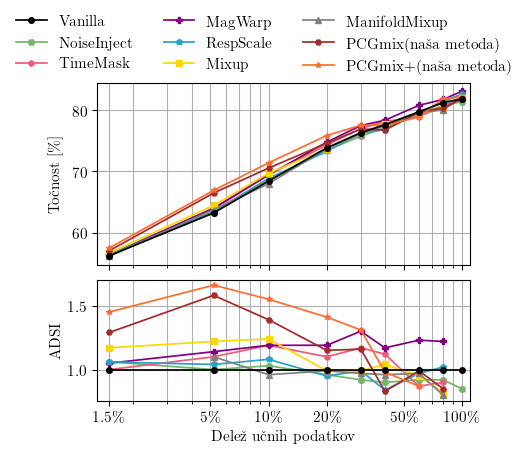

In [22]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('text.latex', preamble=r'\usepackage{amsmath}')
plt.rc('font', size=11)

methods = [
          'base', 
          'gaussiannoise(25,40)',
          'timemask(0.2)',
          'magnitudewarp(0.2,4)',
          #'timewarp(0.05,4)',
          'respiratoryscale(12,20)',
          'mixup(same)',
          'latentmixup',
          'durratiomixup',
          'durmixmagwarp(0.2,4)',
        ]

methods_fmts = ['-o',
                '-X',
                '-h',
                '-P',
                '-p',
                '-s',
                '-^',
                '-H',
                '-*'
               ]

methods_abbrvs = [
            'Vanilla',
            'NoiseInject',
            'TimeMask',
            'MagWarp',
            #'TimeWarp',
            'RespScale',
            'Mixup',
            'ManifoldMixup',
            'PCGmix',
            'PCGmix+',
         ]

methods_colors = [
    'k',
    '#73B66B',
    '#EF597B',
    'purple',
    '#29A2C6',
    'gold',
    'grey',
    'brown',
    '#FF6D31'
]

n_fractions = [0.015, 0.052, 0.1, 0.2, 0.3, 0.4, 0.6, 0.8, 1.0]

lw = 1.25
fac = 0.9
marksize = 4
fig, axes = plt.subplots(2, 1, figsize = (4.6*fac, 4.125), gridspec_kw={'height_ratios': [1.5, 1], 'hspace':0.1})
plt.subplots_adjust(left=0, hspace=0.1, wspace=0.1) 

### Accuracy
#acc_mean_resnet
#ri_mean_resnet
#adsi_resnet
for i, (method, method_abbrv, method_c, method_fmt) in enumerate(zip(methods, methods_abbrvs, methods_colors, methods_fmts)):
    accs_arr = acc_mean_resnet[acc_mean_resnet['Method']==method_abbrv]['resnet acc'].values
    if method_abbrv == 'Vanilla':
        axes[0].plot(n_fractions, accs_arr, method_fmt, color= method_c, linewidth=lw, markersize=marksize, zorder=3)
    else:
        axes[0].plot(n_fractions, accs_arr, method_fmt, color= method_c, linewidth=lw, markersize=marksize)
axes[0].set_ylabel('Točnost [\%]') 
    
# ADSI improvement graph
for i, (method, method_abbrv, method_c, method_fmt) in enumerate(zip(methods, methods_abbrvs, methods_colors, methods_fmts)):
    adsi_arr = adsi_resnet[adsi_resnet['Method']==method_abbrv]['resnet adsi'].values
    if method_abbrv in ['Vanilla']: 
        axes[1].plot(n_fractions, [1 for i in n_fractions], method_fmt, color= method_c, label=f'{method_abbrv}', markersize=marksize, linewidth=lw, zorder=3)  
        continue
    # plot   
    else:
        axes[1].plot(n_fractions, adsi_arr, method_fmt, color= method_c, label=f'{method_abbrv}', markersize=marksize, linewidth=lw)  
axes[1].set_xlabel('Delež učnih podatkov', fontsize=11)
axes[1].set_ylabel('ADSI', fontsize=11)
#plt.legend(ncol=3, bbox_to_anchor=(0, -1.4), loc="upper left")#, bbox_to_anchor=(1.7,0.5))

for ax in axes:
    ax.set_xscale('log')
    labels = [item.get_text() for item in ax.get_xticklabels()]
    #print(len(labels), labels)
    ax.set_xticks([0.015, 0.05, 0.1, 0.2, 0.5, 1.0])
    #print(len(labels), labels)
    labels = ['1.5\%','5\%', '10\%','20\%', '50\%','100\%']
    ax.set_xticklabels(labels, fontsize=11)
#     major_ticks = np.linspace(0, 1, 11)
#     ax.set_xticks(major_ticks)
    ax.grid(which='both')
    ax.set_xlim(0.013, 1.1)
        

for ax in fig.get_axes():
    ax.label_outer()  
    
fig.align_ylabels(axes)
      
# save legend separately
legend = plt.legend(ncol=3, bbox_to_anchor=(1.15,3.3), frameon=False, fontsize=11)
legend.get_texts()[-2].set_text('PCGmix(naša metoda)')
legend.get_texts()[-1].set_text('PCGmix+(naša metoda)')
fig  = legend.figure
fig.canvas.draw()
bbox  = legend.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
#legend.remove()
    
# save the plot
plt.tight_layout()
for extension in ['jpg', 'pdf', 'png']:
    FILENAME=os.path.join(RESULTS, f'ARIS_PhysioNet_acc_ADSI_resnet_slo.{extension}')
    plt.savefig(FILENAME, dpi=600, bbox_inches='tight')
plt.show()
plt.close()

### Accuracy + Relative improvement + ADSI same graph (Potes)

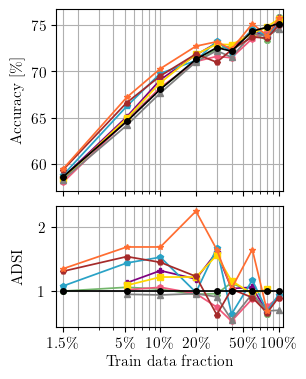

In [34]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('text.latex', preamble=r'\usepackage{amsmath}')
plt.rc('font', size=11)

methods = [
          'base', 
          'gaussiannoise(25,40)',
          'timemask(0.2)',
          'magnitudewarp(0.2,4)',
          #'timewarp(0.05,4)',
          'respiratoryscale(12,20)',
          'mixup(same)',
          'latentmixup',
          'durratiomixup',
          'durmixmagwarp(0.2,4)',
        ]

methods_fmts = ['-o',
                '-X',
                '-h',
                '-P',
                '-p',
                '-s',
                '-^',
                '-H',
                '-*'
               ]

methods_abbrvs = [
            'Vanilla',
            'NoiseInject',
            'TimeMask',
            'MagWarp',
            #'TimeWarp',
            'RespScale',
            'Mixup',
            'ManifoldMixup',
            'PCGmix',
            'PCGmix+',
         ]

methods_colors = [
    'k',
    '#73B66B',
    '#EF597B',
    'purple',
    '#29A2C6',
    'gold',
    'grey',
    'brown',
    '#FF6D31'
]

n_fractions = [0.015, 0.052, 0.1, 0.2, 0.3, 0.4, 0.6, 0.8, 1.0]

lw = 1.25
fac = 0.55
marksize = 4
fig, axes = plt.subplots(2, 1, figsize = (4.6*fac, 7.5*fac), gridspec_kw={'height_ratios': [1.5, 1], 'hspace':0.1})
plt.subplots_adjust(left=0, hspace=0.1, wspace=0.1) 

### Accuracy
#acc_mean_potes
#ri_mean_potes
#adsi_potes
for i, (method, method_abbrv, method_c, method_fmt) in enumerate(zip(methods, methods_abbrvs, methods_colors, methods_fmts)):
    accs_arr = acc_mean_potes[acc_mean_potes['Method']==method_abbrv]['Potes acc'].values
    if method_abbrv == 'Vanilla':
        axes[0].plot(n_fractions, accs_arr, method_fmt, color= method_c, linewidth=lw, markersize=marksize, zorder=3)
    else:
        axes[0].plot(n_fractions, accs_arr, method_fmt, color= method_c, linewidth=lw, markersize=marksize)
axes[0].set_ylabel('Accuracy [\%]') 
    

# ADSI improvement graph
for i, (method, method_abbrv, method_c, method_fmt) in enumerate(zip(methods, methods_abbrvs, methods_colors, methods_fmts)):
    adsi_arr = adsi_potes[adsi_potes['Method']==method_abbrv]['Potes adsi'].values
    if method_abbrv in ['Vanilla']: 
        axes[1].plot(n_fractions, [1 for i in n_fractions], method_fmt, color= method_c, label=f'{method_abbrv}', markersize=marksize, linewidth=lw, zorder=3)  
        continue
    # plot   
    else:
        axes[1].plot(n_fractions, adsi_arr, method_fmt, color= method_c, label=f'{method_abbrv}', markersize=marksize, linewidth=lw)  
axes[1].set_xlabel('Training-data fraction', fontsize=11)
axes[1].set_ylabel('ADSI', fontsize=11)
#plt.legend(ncol=3, bbox_to_anchor=(0, -1.4), loc="upper left")#, bbox_to_anchor=(1.7,0.5))

for ax in axes:
    ax.set_xscale('log')
    labels = [item.get_text() for item in ax.get_xticklabels()]
    #print(len(labels), labels)
    ax.set_xticks([0.015, 0.05, 0.1, 0.2, 0.5, 1.0])
    #print(len(labels), labels)
    labels = ['1.5\%','5\%', '10\%','20\%', '50\%','100\%']
    ax.set_xticklabels(labels, fontsize=11)
#     major_ticks = np.linspace(0, 1, 11)
#     ax.set_xticks(major_ticks)
    ax.grid(which='both')
    ax.set_xlim(0.013, 1.1)
        

for ax in fig.get_axes():
    ax.label_outer()  
    
fig.align_ylabels(axes)
      
# save legend separately
legend = plt.legend(ncol=3, bbox_to_anchor=(1.02,-0.4), frameon=False, fontsize=11)
fig  = legend.figure
fig.canvas.draw()
bbox  = legend.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
#fig.savefig(filename, dpi="figure", bbox_inches=bbox)
for extension in ['jpg', 'pdf', 'png']:
    FILENAME=os.path.join(RESULTS, f'PhysioNet_acc_ADSI_legend.{extension}')
    fig.savefig(FILENAME, dpi=600, bbox_inches=bbox)  
legend.remove()
    
# save the plot
plt.tight_layout()
for extension in ['jpg', 'pdf', 'png']:
    FILENAME=os.path.join(RESULTS, f'PhysioNet_acc_ADSI_potes.{extension}')
    plt.savefig(FILENAME, dpi=600, bbox_inches='tight')
plt.show()
plt.close()

### SPECTROGRAMS: Main performance table

In [38]:
def propagate_error(a, da, b, db):
    re_a = (da/a)**2
    re_b = (db/b)**2
    re = np.sqrt(re_a+re_b) # this is (dc/c)
    return re

def relative_improv_over_vanilla(accuracy_df, std_df, n_fracs=[0.015, 0.052, 0.1, 0.2, 0.3, 0.4, 0.6, 0.8, 1.0]):
    n_fracs = [str(x) for x in n_fracs]
    ri_mean = copy.deepcopy(accuracy_df)
    ri_mean.loc[:, n_fracs]=np.nan
    ri_std = copy.deepcopy(accuracy_df)
    ri_std.loc[:, n_fracs]=np.nan
    for i in range(len(ri_mean)):
        if i==0: continue
        for n_frac in n_fracs:
            # vanilla
            b = accuracy_df.loc[0,n_frac]
            db = std_df.loc[0,n_frac]
            # method
            a = accuracy_df.loc[i,n_frac]
            da = std_df.loc[i,n_frac]
            re = propagate_error(a, da, b, db)
            #ri_df.loc[i,n_frac] = f'_{np.round((a/b-1)*100, 2)}\ pm{np.round(re*a/b*100, 2)}_'    
            ri_mean.loc[i,n_frac] = np.round((a/b-1)*100, 2)
            ri_std.loc[i,n_frac] = {np.round(re*a/b*100, 2)}
    return ri_mean, ri_std  

custom_order = ['Vanilla', 'FreqMask', 'TimeMask', 'Cutout', 'Mixup', 'ManifoldMixup', 'PCGmix']
# resnet9
acc_mean_resnet = pd.read_csv(os.path.join(EXPERIMENTS, 'PhysioNet(spec128)_resnet9_all_seeds_Accuracy-mean.csv'))
acc_mean_resnet = acc_mean_resnet.set_index('Method').loc[custom_order].reset_index()
acc_std_resnet = pd.read_csv(os.path.join(EXPERIMENTS, 'PhysioNet(spec128)_resnet9_all_seeds_Accuracy-std.csv'))
acc_std_resnet = acc_std_resnet.set_index('Method').loc[custom_order].reset_index()
ri_mean_resnet, ri_std_resnet = relative_improv_over_vanilla(acc_mean_resnet, acc_std_resnet)
adsi_resnet = pd.read_csv(os.path.join(EXPERIMENTS, 'PhysioNet(spec128)_resnet9_all_seeds_adsi.csv'))
adsi_resnet = adsi_resnet.set_index('Method').loc[custom_order].reset_index()


# Reshape the dataframes
# resnet9
acc_mean_resnet = pd.melt(acc_mean_resnet, id_vars=['Method'], var_name=['N frac'], value_name='resnet acc')[['N frac', 'Method', 'resnet acc']]
acc_std_resnet = pd.melt(acc_std_resnet, id_vars=['Method'], var_name=['N frac'], value_name='resnet acc sd')[['N frac', 'Method', 'resnet acc sd']]
ri_mean_resnet = pd.melt(ri_mean_resnet, id_vars=['Method'], var_name=['N frac'], value_name='resnet ri')[['N frac', 'Method', 'resnet ri']]
ri_std_resnet = pd.melt(ri_std_resnet, id_vars=['Method'], var_name=['N frac'], value_name='resnet ri sd')[['N frac', 'Method', 'resnet ri sd']]
adsi_resnet = pd.melt(adsi_resnet, id_vars=['Method'], var_name=['N frac'], value_name='resnet adsi')[['N frac', 'Method', 'resnet adsi']]
# concat
dfs = [
    acc_mean_resnet,
    acc_std_resnet,
    ri_mean_resnet,
    ri_std_resnet,
    adsi_resnet
    ]
results_df = pd.concat([dfs[0].iloc[:, :2]] + [df.iloc[:, 2:] for df in dfs], axis=1)
results_df['resnet acc'] =  results_df['resnet acc'].astype(str) + ' _\ pm_ ' + results_df['resnet acc sd'].astype(str) 
results_df['resnet ri'] =  results_df['resnet ri'].astype(str) + ' _\ pm_ ' + results_df['resnet ri sd'].astype(str) 
results_df = results_df[['N frac', 'Method', 'resnet acc', 'resnet ri', 'resnet adsi']]
results_df = results_df[['N frac', 'Method', 'resnet acc', 'resnet adsi']]
# clean it
results_df = results_df.replace({np.nan:'-', 'Vanilla': 'Vanilla (no aug.)', 'PCGmix':'PCGmix (ours)'})
results_df = results_df.astype(str)
results_df = results_df.replace({'nan _\ pm_ nan':'-'})

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(results_df)

,N frac,Method,resnet acc,resnet adsi
0,0.015,Vanilla (no aug.),56.87 _\ pm_ 5.64,-
1,0.015,FreqMask,56.67 _\ pm_ 5.49,-
2,0.015,TimeMask,56.79 _\ pm_ 5.54,-
3,0.015,Cutout,56.76 _\ pm_ 5.64,-
4,0.015,Mixup,57.67 _\ pm_ 5.71,1.22
5,0.015,ManifoldMixup,56.69 _\ pm_ 5.53,-
6,0.015,PCGmix (ours),58.55 _\ pm_ 6.48,1.46
7,0.052,Vanilla (no aug.),65.79 _\ pm_ 4.55,-
8,0.052,FreqMask,65.5 _\ pm_ 5.3,0.98
9,0.052,TimeMask,66.72 _\ pm_ 4.97,1.14


### SPECTROGRAMS: Accuracy + Relative improvement + ADSI same graph (resnet9)

/tmp/ipykernel_664585/733173114.py:110: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


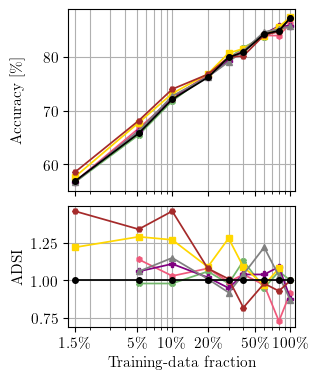

In [40]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('text.latex', preamble=r'\usepackage{amsmath}')
plt.rc('font', size=11)

methods = [
     'base',
     'freqmask(0.1)',
     'timemask(0.1)',
     'cutout(0.25,0.25)',
     'mixup(same)',
     'latentmixup',
     'durratiomixup',
    ]

methods_fmts = ['-o',
                '-X',
                '-h',
                '-P',
                '-s',
                '-^',
                '-H',
               ]

methods_abbrvs = [
            'Vanilla',
            'FreqMask',
            'TimeMask',
            'Cutout',
            'Mixup',
            'ManifoldMixup',
            'PCGmix',
         ]

methods_colors = [
    'k',
    '#73B66B',
    '#EF597B',
    'purple',
    'gold',
    'grey',
    'brown',
]

n_fractions = [0.015, 0.052, 0.1, 0.2, 0.3, 0.4, 0.6, 0.8, 1.0]

lw = 1.25
fac = 0.55
marksize = 4
fig, axes = plt.subplots(2, 1, figsize = (4.6*fac, 7.5*fac), gridspec_kw={'height_ratios': [1.5, 1], 'hspace':0.1})
plt.subplots_adjust(left=0, hspace=0.1, wspace=0.1) 

### Accuracy
#acc_mean_resnet
#ri_mean_resnet
#adsi_resnet
for i, (method, method_abbrv, method_c, method_fmt) in enumerate(zip(methods, methods_abbrvs, methods_colors, methods_fmts)):
    accs_arr = acc_mean_resnet[acc_mean_resnet['Method']==method_abbrv]['resnet acc'].values
    if method_abbrv == 'Vanilla':
        axes[0].plot(n_fractions, accs_arr, method_fmt, color= method_c, linewidth=lw, markersize=marksize, zorder=3)
    else:
        axes[0].plot(n_fractions, accs_arr, method_fmt, color= method_c, linewidth=lw, markersize=marksize)
axes[0].set_ylabel('Accuracy [\%]') 
    

# ADSI improvement graph
for i, (method, method_abbrv, method_c, method_fmt) in enumerate(zip(methods, methods_abbrvs, methods_colors, methods_fmts)):
    adsi_arr = adsi_resnet[adsi_resnet['Method']==method_abbrv]['resnet adsi'].values
    if method_abbrv in ['Vanilla']: 
        axes[1].plot(n_fractions, [1 for i in n_fractions], method_fmt, color= method_c, label=f'{method_abbrv}', markersize=marksize, linewidth=lw, zorder=3)  
        continue
    # plot   
    else:
        axes[1].plot(n_fractions, adsi_arr, method_fmt, color= method_c, label=f'{method_abbrv}', markersize=marksize, linewidth=lw)  
axes[1].set_xlabel('Training-data fraction', fontsize=11)
axes[1].set_ylabel('ADSI', fontsize=11)
#plt.legend(ncol=3, bbox_to_anchor=(0, -1.4), loc="upper left")#, bbox_to_anchor=(1.7,0.5))

for ax in axes:
    ax.set_xscale('log')
    labels = [item.get_text() for item in ax.get_xticklabels()]
    #print(len(labels), labels)
    ax.set_xticks([0.015, 0.05, 0.1, 0.2, 0.5, 1.0])
    #print(len(labels), labels)
    labels = ['1.5\%','5\%', '10\%','20\%', '50\%','100\%']
    ax.set_xticklabels(labels, fontsize=11)
#     major_ticks = np.linspace(0, 1, 11)
#     ax.set_xticks(major_ticks)
    ax.grid(which='both')
    ax.set_xlim(0.013, 1.1)
        

for ax in fig.get_axes():
    ax.label_outer()  
    
fig.align_ylabels(axes)
      
# save legend separately
legend = plt.legend(ncol=3, bbox_to_anchor=(1.02,-0.4), frameon=False, fontsize=11)
fig  = legend.figure
fig.canvas.draw()
bbox  = legend.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
#fig.savefig(filename, dpi="figure", bbox_inches=bbox)
for extension in ['jpg', 'pdf', 'png']:
    FILENAME=os.path.join(RESULTS, f'PhysioNet(spec)_acc_ADSI_legend.{extension}')
    fig.savefig(FILENAME, dpi=600, bbox_inches=bbox)  
legend.remove()
    
# save the plot
plt.tight_layout()
for extension in ['jpg', 'pdf', 'png']:
    FILENAME=os.path.join(RESULTS, f'PhysioNet(spec)_acc_ADSI_resnet.{extension}')
    plt.savefig(FILENAME, dpi=600, bbox_inches='tight')
plt.show()
plt.close()

### PhysioNet Classical Features t-SNE Visualization

Figure saved to: ../../../mnt/eol/Zacasno/davidsusic/CHF/thesis/PhysioNet_feature_space_train.png


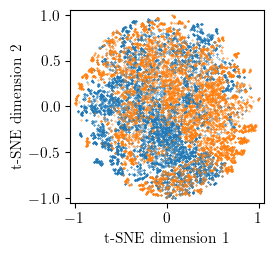

Figure saved to: ../../../mnt/eol/Zacasno/davidsusic/CHF/thesis/PhysioNet_feature_space_test.png


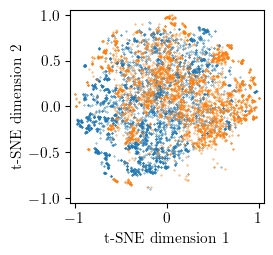

In [3]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('text.latex', preamble=r'\usepackage{amsmath}')
plt.rc('font', size=11)

# open the features
fts_tsne = pd.read_csv(os.path.join(CHF, 'features', f'tableFeatures(all)-Python_raw_filtBandIIR(ZP)4-25-400_normRMS_seg_tsne.csv'))
for col in ['tsne1', 'tsne2']:
    #fts_tsne[col] = (fts_tsne[col]-fts_tsne[col].mean())/fts_tsne[col].std()
    fts_tsne[col] = (fts_tsne[col]-fts_tsne[col].min())/(fts_tsne[col].max()-fts_tsne[col].min())*2-1

train_wavs = np.loadtxt(os.path.join(CHF, 'features', 'PhysioNet_seed_data__1100001_nfrac_1.0_valid_False.txt'), dtype=str)
test_wavs = pd.read_csv(os.path.join(CHF, 'features', 'REFERENCE.csv'), header=None)[0].values
    
train_tsne = fts_tsne[fts_tsne['ID'].isin(train_wavs)]
test_tsne = fts_tsne[fts_tsne['ID'].isin(test_wavs)]

# plot
# train set
plt.figure(figsize=(2.5, 2.5))
train_tsne_0 = train_tsne[train_tsne['class']==0]
train_tsne_1 = train_tsne[train_tsne['class']==1]
plt.scatter(train_tsne_0['tsne1'].values, train_tsne_0['tsne2'], color='#1f77b4', s=0.1)
plt.scatter(train_tsne_1['tsne1'].values, train_tsne_1['tsne2'], color='#ff7f0e', s=0.1)
plt.scatter(10, 10, color='#1f77b4', label='Normal', s=10)
plt.scatter(10, 10, color='#ff7f0e', label='Abnormal', s=10)

plt.xlabel('t-SNE dimension 1', fontsize=11)
plt.ylabel('t-SNE dimension 2', fontsize=11)
#plt.grid()
plt.xlim((-1.05, 1.05))
plt.ylim((-1.05, 1.05))

# save legend separately
legend = plt.legend(ncol=2, bbox_to_anchor=(1.13,1.2), frameon=False, fontsize=11)
fig  = legend.figure
fig.canvas.draw()
bbox  = legend.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
#fig.savefig(filename, dpi="figure", bbox_inches=bbox)
for extension in ['jpg', 'pdf', 'png']:
    FILENAME=os.path.join(RESULTS, f'PhysioNet_feature_space_legend.{extension}')
    fig.savefig(FILENAME, dpi=600, bbox_inches=bbox)  
legend.remove()

for extension in ['jpg', 'pdf', 'png']:
    FILENAME = f'PhysioNet_feature_space_train.{extension}'
    FILENAME = os.path.join(RESULTS, FILENAME)
    plt.savefig(FILENAME, dpi=600, bbox_inches='tight')
print(f'Figure saved to: {FILENAME}')
plt.show()
plt.close()

# test set
plt.figure(figsize=(2.5, 2.5))
test_tsne_0 = test_tsne[test_tsne['class']==0]
test_tsne_1 = test_tsne[test_tsne['class']==1]
plt.scatter(test_tsne_0['tsne1'].values, test_tsne_0['tsne2'], color= '#1f77b4', s=0.1)
plt.scatter(test_tsne_1['tsne1'].values, test_tsne_1['tsne2'], color='#ff7f0e', s=0.1)
plt.scatter(10, 10, color= '#1f77b4', label='Normal', s=10)
plt.scatter(10, 10, color='#ff7f0e', label='Abnormal', s=10)

plt.xlabel('t-SNE dimension 1', fontsize=11)
plt.ylabel('t-SNE dimension 2', fontsize=11)
#plt.grid()
plt.xlim((-1.05, 1.05))
plt.ylim((-1.05, 1.05))

# save legend separately
legend = plt.legend(ncol=2, bbox_to_anchor=(1.13,1.2), frameon=False, fontsize=11)
fig  = legend.figure
fig.canvas.draw()
bbox  = legend.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
#fig.savefig(filename, dpi="figure", bbox_inches=bbox)
for extension in ['jpg', 'pdf', 'png']:
    FILENAME=os.path.join(RESULTS, f'PhysioNet_feature_space_legend.{extension}')
    fig.savefig(FILENAME, dpi=600, bbox_inches=bbox)  
legend.remove()
    
for extension in ['jpg', 'pdf', 'png']:
    FILENAME = f'PhysioNet_feature_space_test.{extension}'
    FILENAME = os.path.join(RESULTS, FILENAME)
    plt.savefig(FILENAME, dpi=600, bbox_inches='tight')
print(f'Figure saved to: {FILENAME}')
plt.show()
plt.close()

Data seed: 1001001; N fraction: 0.015; Number of recordings: 10
Data seed: 1005001; N fraction: 0.052; Number of recordings: 30
Data seed: 1010001; N fraction: 0.1; Number of recordings: 56
Data seed: 1020001; N fraction: 0.2; Number of recordings: 112
Data seed: 1030001; N fraction: 0.3; Number of recordings: 168
Data seed: 1001002; N fraction: 0.015; Number of recordings: 10
Data seed: 1005002; N fraction: 0.052; Number of recordings: 30
Data seed: 1010002; N fraction: 0.1; Number of recordings: 56
Data seed: 1020002; N fraction: 0.2; Number of recordings: 112
Data seed: 1030002; N fraction: 0.3; Number of recordings: 168
Data seed: 1001003; N fraction: 0.015; Number of recordings: 10
Data seed: 1005003; N fraction: 0.052; Number of recordings: 30
Data seed: 1010003; N fraction: 0.1; Number of recordings: 56
Data seed: 1020003; N fraction: 0.2; Number of recordings: 112
Data seed: 1030003; N fraction: 0.3; Number of recordings: 168
Figure saved to: ../../../mnt/eol/Zacasno/davidsusic

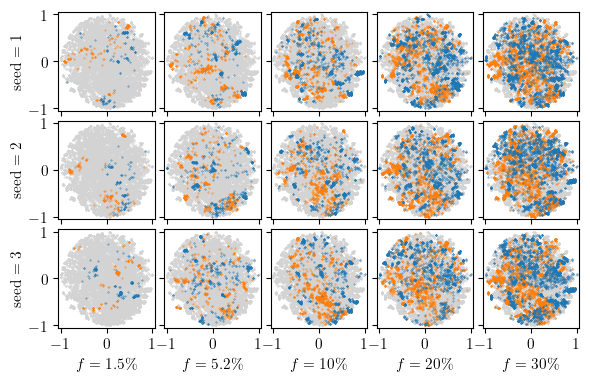

In [26]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('text.latex', preamble=r'\usepackage{amsmath}')
plt.rc('font', size=11)

fts_tsne = pd.read_csv(os.path.join(CHF, 'features', f'tableFeatures(all)-Python_raw_filtBandIIR(ZP)4-25-400_normRMS_seg_tsne.csv'))
for col in ['tsne1', 'tsne2']:
    #fts_tsne[col] = (fts_tsne[col]-fts_tsne[col].mean())/fts_tsne[col].std()
    fts_tsne[col] = (fts_tsne[col]-fts_tsne[col].min())/(fts_tsne[col].max()-fts_tsne[col].min())*2-1

train_wavs = np.loadtxt(os.path.join(CHF, 'features', 'PhysioNet_seed_data__1100001_nfrac_1.0_valid_False.txt'), dtype=str)
test_wavs = pd.read_csv(os.path.join(CHF, 'features', 'REFERENCE.csv'), header=None)[0].values
    
train_tsne = fts_tsne[fts_tsne['ID'].isin(train_wavs)]
test_tsne = fts_tsne[fts_tsne['ID'].isin(test_wavs)]

dataseeds = [1, 2, 3]
dataseed_labels = ['1', '2', '3']
n_fractions = [0.015, 0.052, 0.1, 0.2, 0.3]
s_size = 0.1
#fig, axes = plt.subplots(len(dataseeds), len(n_fractions), figsize=(8.2, 5), gridspec_kw={'wspace':0.1, 'hspace':0.1})
fac=0.82
fig, axes = plt.subplots(len(dataseeds), len(n_fractions), figsize=(8.2*fac, 5*fac), gridspec_kw={'wspace':0.1, 'hspace':0.1})
for i, dataseed in enumerate(dataseeds):
    for j, n_fraction in enumerate(n_fractions):
        if n_fraction == 0.015:
            seed_data = 1001000 + dataseed
        elif n_fraction == 0.052:
            seed_data = 1005000 + dataseed
        elif n_fraction == 0.1:
            seed_data = 1010000 + dataseed    
        elif n_fraction == 0.2:
            seed_data = 1020000 + dataseed
        elif n_fraction == 0.3:
            seed_data = 1030000 + dataseed
        TRAIN_WAV_SUB = os.path.join(EOL, 'subsets_new', f'PhysioNet_seed(data)={seed_data}_nfrac={n_fraction}_valid=False.txt')
        train_wav_sub = list(np.genfromtxt(TRAIN_WAV_SUB, dtype='str'))
        print(f'Data seed: {seed_data}; N fraction: {n_fraction}; Number of recordings: {len(train_wav_sub)}')
        # all train data
        axes[i][j].scatter(train_tsne['tsne1'], train_tsne['tsne2'], color='lightgrey', s=s_size )
        # selected train data
        train_tsne_nfrac = train_tsne[train_tsne.ID.isin(train_wav_sub)]
        axes[i][j].scatter(train_tsne_nfrac[train_tsne_nfrac['class']==0]['tsne1'], train_tsne_nfrac[train_tsne_nfrac['class']==0]['tsne2'], color = '#ff7f0e', s=s_size )
        axes[i][j].scatter(train_tsne_nfrac[train_tsne_nfrac['class']==1]['tsne1'], train_tsne_nfrac[train_tsne_nfrac['class']==1]['tsne2'], color = '#1f77b4', s=s_size )
        if n_fraction == 0.015:
            axes[i][j].set_xlabel(f'$f=1.5\%$', fontsize=11)
        elif n_fraction == 0.052:
            axes[i][j].set_xlabel(f'$f=5.2\%$', fontsize=11)
        elif n_fraction == 0.1:
            axes[i][j].set_xlabel(f'$f=10\%$', fontsize=11)   
        elif n_fraction == 0.2:
            axes[i][j].set_xlabel(f'$f=20\%$', fontsize=11)
        elif n_fraction == 0.3:
            axes[i][j].set_xlabel(f'$f=30\%$', fontsize=11)
        
        axes[i][j].set_ylabel(f'seed $={dataseed_labels[i]}$', fontsize=11)
#         axes[i][j].yaxis.set_label_position("right")
#         axes[i][j].yaxis.tick_right()
        axes[i][j].set_xlim([-1.05,1.05])
        axes[i][j].set_ylim([-1.05,1.05])
        
axes[0][0].scatter([10], [10], color = '#ff7f0e', s=10, label='Abnormal')
axes[0][0].scatter([10], [10], color = '#1f77b4', s=10, label='Normal')

#fig.supxlabel(f'Train data fraction', fontsize=11, y=0.0)
#fig.supylabel('Data sampling RNG seed', fontsize=11, x=0.05)
for ax in fig.get_axes():
    ax.label_outer()

# # save legend separately
# legend = plt.legend(ncol=2, bbox_to_anchor=(1.13,1.2), frameon=False, fontsize=11)
# fig  = legend.figure
# fig.canvas.draw()
# bbox  = legend.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
# #fig.savefig(filename, dpi="figure", bbox_inches=bbox)
# for extension in ['jpg', 'pdf', 'png']:
#     FILENAME=os.path.join(RESULTS, f'PhysioNet_feature_space_legend.{extension}')
#     fig.savefig(FILENAME, dpi=600, bbox_inches=bbox)  
# legend.remove()
    
for extension in ['jpg', 'pdf', 'png']:
    FILENAME = f'PhysioNet_feature_space_N_selections_grid.{extension}'
    FILENAME = os.path.join(RESULTS, FILENAME)
    plt.savefig(FILENAME, dpi=600, bbox_inches='tight')
print(f'Figure saved to: {FILENAME}')
plt.show()
plt.close()

### Parameter Sensitivity Analysis: Number of Training Epochs

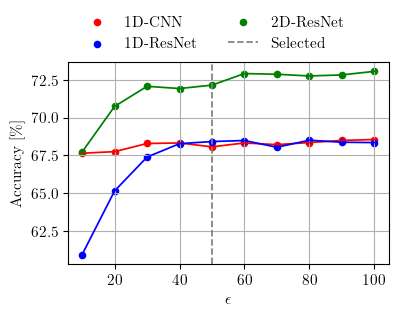

In [10]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('text.latex', preamble=r'\usepackage{amsmath}')
plt.rc('font', size=11)

potes = [67.6434,67.7512,68.2892 ,68.3228 ,68.0672,68.3238,68.2146,68.35,68.4912,68.5516]
potes_epochs = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
resnet1d = [60.9568,65.1584,67.3942,68.2758,68.4176,68.4844,68.0408,68.5056,68.3706, 68.3498]
resnet1d_epochs = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
resnet2d = [67.732333,70.740667,72.064333,71.918333,72.143,72.907 ,72.860667,72.749,72.817,73.051667]
resnet2d_epochs = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

s = 20
lw=1.25
plt.figure(figsize=(4, 3.5))
plt.scatter(potes_epochs, potes, label='1D-CNN', color='r', s=s)
plt.plot(potes_epochs, potes, color='r', lw=lw)
plt.scatter(resnet1d_epochs, resnet1d, label='1D-ResNet', color='b', s=s)
plt.plot(resnet1d_epochs, resnet1d, color='b', lw=lw)
plt.scatter(resnet2d_epochs, resnet2d, label='2D-ResNet', color='g', s=s)
plt.plot(resnet2d_epochs, resnet2d, color='g', lw=lw)
#plt.grid()
plt.ylabel('Accuracy [\%]')
plt.xlabel(r'$\epsilon$')
plt.axvline(x=50, linestyle='--', color='grey', label='Selected', lw=lw)

legend = plt.legend(ncol=2, bbox_to_anchor=(0.9,1.3), frameon=False, fontsize=11)

plt.grid()

# save the plot
plt.tight_layout()
for extension in ['jpg', 'pdf', 'png']:
    FILENAME=os.path.join(RESULTS, f'aug_param_sensitivity_epochs.{extension}')
    plt.savefig(FILENAME, dpi=600, bbox_inches='tight')
plt.show()
plt.close()

### Parameter Sensitivity Analysis: Augmentation Probability

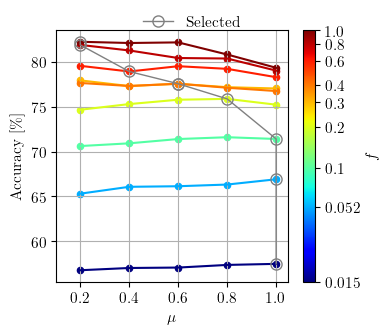

In [4]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('text.latex', preamble=r'\usepackage{amsmath}')
plt.rc('font', size=11)

cps = [0.2, 0.4, 0.6, 0.8, 1.0]
n_fractions = [0.015, 0.052, 0.1, 0.2, 0.3, 0.4, 0.6, 0.8, 1.0]
nfrac_015 =[56.785465,57.036366,57.083994,57.377177,57.495195]
nfrac_052 =[65.3102,66.0745,66.1382,66.3262,66.9125]
nfrac_010 =[70.6124,70.9156,71.3934,71.5954,71.4004]
nfrac_020 =[74.6524,75.2844,75.7696,75.8644,75.2176]
nfrac_030 =[77.92375,77.2925,77.545,77.1675,77.020625]
nfrac_040 =[77.636667,77.3,77.5525,77.103333,76.7375]
nfrac_060 =[79.54375,78.91375,79.5025,79.2075,78.28]
nfrac_080 =[81.873333,81.256667,80.413333,80.358333,79.013333]
nfrac_100 =[82.222,82.086,82.154,80.806,79.326]

nfracs = [nfrac_015,nfrac_052,nfrac_010,nfrac_020,nfrac_030,nfrac_040,nfrac_060,nfrac_080,nfrac_100]

#normalize = mcolors.Normalize(vmin=min(n_fractions), vmax=max(n_fractions))
normalize = mcolors.LogNorm(vmin=min(n_fractions), vmax=max(n_fractions))
colormap = cm.jet

lw=1
plt.figure(figsize=(4, 3.5))
colors = []
for n_fraction, nfrac in zip(n_fractions, nfracs):             
    plt.plot(cps, nfrac, color=colormap(normalize(n_fraction)))#, label=fr"$\alpha={alf}$")
    plt.scatter(cps, nfrac, color=colormap(normalize(n_fraction)), s=20)
    colors.append(colormap(normalize(n_fraction)))
x_m_cps = [1.0, 1.0, 1.0, 0.8, 0.6, 0.6, 0.4, 0.2, 0.2]
y_m_accs = [nfrac[cps.index(x)] for nfrac, x in zip(nfracs, x_m_cps)]
plt.plot(x_m_cps, y_m_accs, '-o', color='grey', linewidth=lw, markersize=8, mfc='none', label='Selected')
plt.xlim((0.1, 1.05))
plt.xlabel(r'$\mu$')
plt.ylabel(r'Accuracy [\%]')
plt.grid()

# bounds = n_fractions#[x*1.1 for x in n_fractions]  # Add an upper bound to close the last interval
# normalize = mcolors.BoundaryNorm(boundaries=bounds, ncolors=len(n_fractions))
# colormap, _ = mcolors.from_levels_and_colors(range(len(n_fractions) + 1), colors)
# cbar = plt.colorbar(cm.ScalarMappable(norm=normalize, cmap=colormap), ticks=n_fractions, boundaries=bounds)
# cbar.ax.set_yticklabels([f'{nf}' for nf in n_fractions])

# Add custom colorbar
cbar = plt.colorbar(cm.ScalarMappable(norm=normalize, cmap=colormap), ticks=n_fractions)
cbar.ax.set_yticks(n_fractions)
cbar.ax.set_yticklabels([f'{nf}' for nf in n_fractions])
cbar.ax.set_ylabel(r'$f$', rotation=90)
cbar.ax.tick_params(which='minor', size=0)

legend = plt.legend(ncol=1, bbox_to_anchor=(0.85,1.115), frameon=False, fontsize=11)
# save the plot
plt.tight_layout()
for extension in ['jpg', 'pdf', 'png']:
    FILENAME=os.path.join(RESULTS, f'aug_param_sensitivity_augprobas.{extension}')
    plt.savefig(FILENAME, dpi=600, bbox_inches='tight')
plt.show()
plt.close()

### Parameter Sensitivity Analysis: Mixing Coefficient Distributions

Figure saved to: ../../../mnt/eol/Zacasno/davidsusic/CHF/thesis/mixing_coef_illustration.png


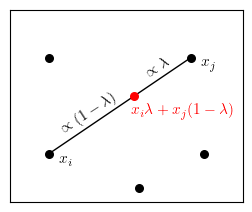

In [157]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('text.latex', preamble=r'\usepackage{amsmath}')
plt.rc('font', size=11)

lw=0.7
marksize=30
lw=1

x_i, y_i = 0.25, 0.4
x_j, y_j = 0.8, 0.6
lam=0.4
x_aug = lam * x_i + (1 - lam) * x_j
y_aug = lam * y_i + (1 - lam) * y_j
x_extra = [0.25, 0.6, 0.85]
y_extra = [0.6, 0.33, 0.4]

fig = plt.figure(figsize=(3, 2.5))

plt.scatter(x_i, y_i, color='k', s=marksize)
plt.scatter(x_j, y_j, color='k', s=marksize)
plt.plot([x_i, x_j], [y_i, y_j], color='k', lw=lw)
plt.scatter(x_aug, y_aug, color='r', s=marksize, zorder=100)
plt.scatter(x_extra, y_extra, color='k', s=marksize)

plt.text(x_i+0.04, y_i-0.02, r'$x_i$')
plt.text(x_j+0.04, y_j-0.02, r'$x_j$')
plt.text(x_aug-0.01, y_aug-0.04, r'$x_i\lambda+x_j(1-\lambda)$', color='r')

angle_radians = np.arctan2(y_j - y_i, x_j - x_i)
rot = np.degrees(angle_radians)+13

plt.text((x_i+x_aug)/2-0.13, (y_j+y_aug)/2-0.115, r'$\propto(1-\lambda)$', rotation=rot)
plt.text((x_i+x_aug)/2+0.2, (y_j+y_aug)/2, r'$\propto\lambda$', rotation=rot)

plt.xlim((0.1, 1))
plt.ylim((0.3, 0.7))
plt.xticks([])
plt.yticks([])

for extension in ['jpg', 'pdf', 'png']:
    FILENAME = f'mixing_coef_illustration.{extension}'
    FILENAME = os.path.join(RESULTS, FILENAME)
    plt.savefig(FILENAME, dpi=600, bbox_inches='tight')
print(f'Figure saved to: {FILENAME}')
plt.show()
plt.close()

Figure saved to: ../../../mnt/eol/Zacasno/davidsusic/CHF/thesis/mixing_coef_distribution.png


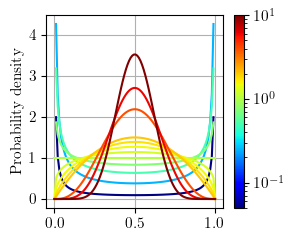

In [11]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('text.latex', preamble=r'\usepackage{amsmath}')
plt.rc('font', size=11)

alphas = [0.2, 0.4, 0.5, 0.6, 0.8, 1.0, 1.2, 1.4, 1.5, 1.6, 1.8]
alphas = [0.05, 0.25, 0.5, 0.75, 1.0, 2, 3, 4, 5, 6, 7, 8, 9, 10]
alphas = [0.05, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2]
alphas = [0.05, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2, 4, 6, 10]
#normalize = mcolors.Normalize(vmin=min(alphas), vmax=max(alphas))
normalize = mcolors.LogNorm(vmin=min(alphas), vmax=max(alphas))
colormap = cm.jet

x = np.linspace(0, 1, 100)
y1 = scipy.stats.beta.pdf(x, 1, 1)
y2 = scipy.stats.beta.pdf(x, 0.5, 0.5)
y3 = scipy.stats.beta.pdf(x, 1.5, 1.5)

# test set
plt.figure(figsize=(2.85, 2.5))
colors = []
for i, alf in enumerate(alphas):
    y = scipy.stats.beta.pdf(x, alf, alf)               
    plt.plot(x, y, color=colormap(normalize(alf)))#, label=fr"$\alpha={alf}$")
    colors.append(colormap(normalize(alf)))

plt.xlim((-0.05, 1.05))
plt.ylabel('Probability density')
# setup (continuous) the colorbar
scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=colormap)
scalarmappaple.set_array(alphas)
scalarmappaple.set_array([])
plt.colorbar(scalarmappaple)
# # discrete colorbar
# cmap, _ = mcolors.from_levels_and_colors(range(len(alphas) + 1), colors)
# sm = cm.ScalarMappable(cmap=cmap, norm=normalize)
# sm.set_array([alphas])
# cbar = plt.colorbar(sm)
# cbar.ax.get_yaxis().labelpad = 1
# cbar.ax.set_ylabel(r'$\alpha$', rotation=90)

plt.grid()
    
for extension in ['jpg', 'pdf', 'png']:
    FILENAME = f'mixing_coef_distribution.{extension}'
    FILENAME = os.path.join(RESULTS, FILENAME)
    plt.savefig(FILENAME, dpi=600, bbox_inches='tight')
print(f'Figure saved to: {FILENAME}')
plt.show()
plt.close()

Figure saved to: ../../../mnt/eol/Zacasno/davidsusic/CHF/thesis/mixing_coef_results.png


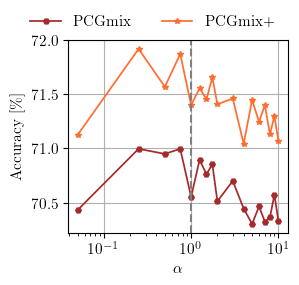

In [8]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('text.latex', preamble=r'\usepackage{amsmath}')
plt.rc('font', size=11)

alphas = [0.05, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2, 3, 4, 5, 6, 7, 8, 9, 10]
lw = 1.25
marksize = 4

base_acc = 68.41760000000001 
base_std = 3.423797634206788
resnet_durmixmagwarp_acc = [71.124608, 71.91922, 71.569052, 71.872082, 71.400702, 71.555584, 71.45457400000001, 71.656594, 71.407436, 71.461308, 71.0438, 71.44784, 71.24582000000001, 71.400702, 71.131342, 71.299692, 71.070736]
resnet_durmixmagwarp_sd = [2.7989148217721804, 2.5088104218533536, 2.75119957918287, 2.503572240035425, 2.592729923496853, 3.0267363668056726, 2.6377087455448893, 2.4666027052940653, 2.749286939754379, 2.5611872902886264, 2.8089741088162414, 2.773230934776258, 2.81542411526221, 2.604073585557059, 2.7738930954231096, 2.8231125460271675, 2.820927175576144]
resnet_durratiomixup_acc = [70.431006, 70.996662, 70.949524, 70.996662, 70.55221800000001, 70.895652, 70.760972, 70.85524799999999, 70.511814, 70.70036599999999, 70.444474, 70.30306, 70.464676, 70.323262, 70.363666, 70.57242000000001, 70.329996]
resnet_durratiomixup_sd = [2.9164440121771573, 2.839489137777427, 2.997984060368566, 2.7411681480631556, 2.876143351134641, 2.726363669156409, 2.8108783997917794, 2.8074885112669645, 2.7577271623574364, 3.0574807280903666, 2.5405035789630364, 2.885422742268452, 3.037056396813203, 3.171428042310908, 3.0111523567305594, 2.925998553109689, 3.116350855084195]

    
plt.figure(figsize=(2.85, 2.5))
#plt.axhline(base_acc, color='k', label='Vanilla')
plt.plot(alphas, resnet_durratiomixup_acc, '-H', color= 'brown', linewidth=lw, markersize=marksize, label='PCGmix')
plt.plot(alphas, resnet_durmixmagwarp_acc, '-*', color= '#FF6D31', linewidth=lw, markersize=marksize, label='PCGmix+')
plt.axvline(x=1, color='grey', linestyle='--')

#plt.xlim((0, 10))
plt.xscale('log')
#plt.ylim(top=72.5)
plt.xlabel(r'$\alpha$')
plt.ylabel('Accuracy [\%]')
#plt.ylim((-0.05, 1.05))
plt.grid()

legend = plt.legend(ncol=3, bbox_to_anchor=(1.0,1.2), frameon=False, fontsize=11)
    
for extension in ['jpg', 'pdf', 'png']:
    FILENAME = f'mixing_coef_results.{extension}'
    FILENAME = os.path.join(RESULTS, FILENAME)
    plt.savefig(FILENAME, dpi=600, bbox_inches='tight')
print(f'Figure saved to: {FILENAME}')
plt.show()
plt.close()


### Mixing Diversity

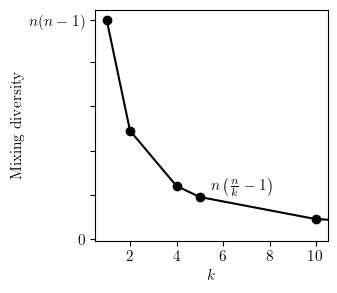

In [156]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('text.latex', preamble=r'\usepackage{amsmath}')
plt.rc('font', size=11)

n = 100
ks = 20
x = np.arange(1, ks + 1)
valid_k = [k for k in x if n % k == 0]
x = np.array(valid_k)
y = [n * (n / k - 1) for k in x]
x2 = np.arange(1, ks + 1)
y2 = [n * (n / k - 1) for k in x2]

plt.figure(figsize=(3, 3))
plt.plot(x, y, color='k')
plt.scatter(x, y, color='k')
plt.text(5.5, 2200, r'$n\left(\frac{n}{k}-1\right)$')

plt.yticks([0, 2000, 4000, 6000, 8000, n*(n-1)], [0, '', '', '', '', r'$n(n-1)$'])
plt.ylabel('Mixing diversity')
plt.xlabel(r'$k$')
plt.xlim([0.5, 10.5])

#plt.grid()

# save the plot
for extension in ['jpg', 'pdf', 'png']:
    FILENAME=os.path.join(RESULTS, f'pairing_mapping_functions_mixing_diversity_function.{extension}')
    plt.savefig(FILENAME, dpi=600, bbox_inches='tight')
plt.show()
plt.close()

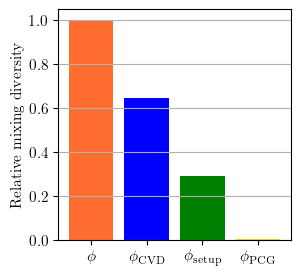

The diveristy of $\phi_{\text{setup}}$ is 0.004781975164898049 of that of $\phi$


In [162]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('text.latex', preamble=r'\usepackage{amsmath}')
plt.rc('font', size=11)

x = [1, 2, 3, 4]
y = [109134402, 70798950, 31956104, 521878]
y_norm = [v/y[0] for v in y]
colors = ['#FF6D31', 'blue', 'green', 'gold']
lbls = [r'$\phi$', r'$\phi_{\text{CVD}}$',r'$\phi_{\text{setup}}$', r'$\phi_{\text{PCG}}$']

plt.figure(figsize=(3, 3))
plt.bar(x, y_norm, align='center', color = colors)
plt.xticks(x, labels=lbls)
plt.ylabel('Relative mixing diversity')
plt.grid(axis='y')

# save the plot
for extension in ['jpg', 'pdf', 'png']:
    FILENAME=os.path.join(RESULTS, f'pairing_mapping_functions_mixing_diversity_theoretical.{extension}')
    plt.savefig(FILENAME, dpi=600, bbox_inches='tight')
plt.show()
plt.close()

print(r'The diveristy of $\phi_{\text{setup}}$ is', y_norm[-1], 'of that of $\phi$')

### Mapping Functions for Determining Mixing Pairs

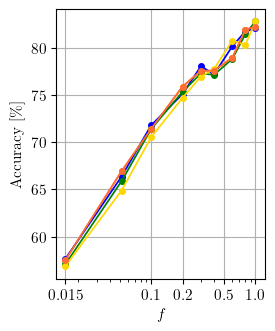

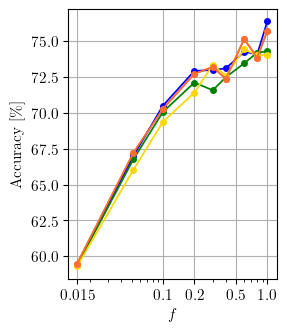

In [16]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('text.latex', preamble=r'\usepackage{amsmath}')
plt.rc('font', size=11)

n_fractions = [0.015, 0.052, 0.1, 0.2, 0.3, 0.4, 0.6, 0.8, 1.0]

# resnet9
default = [57.495195, 66.9125, 71.4004, 75.8644, 77.545, 77.5525, 78.91375, 81.873333, 82.222]
samePCG = [56.842252, 64.8721, 70.512, 74.6792, 76.93375, 77.72, 80.7225, 80.303333, 82.76]
sameCVD = [57.617778, 66.3466, 71.777, 75.0696, 78.029375, 77.16, 80.13375, 81.703333, 82.02]
sameDataset = [57.048739, 65.8557, 71.3804, 75.3132, 77.271875, 77.103333, 78.7875, 81.425, 82.762]
mixAll = [55.204474, 64.3536, 70.1672, 74.8148, 77.755625, 77.468333, 79.88125, 81.256667, 82.422]

lw = 1.25
marksize = 4

plt.figure(figsize=(2.7, 3.5))
plt.plot(n_fractions, default, '-o', color='#FF6D31', label=fr'$\phi$', markersize=marksize, linewidth=lw)
plt.plot(n_fractions, sameCVD, '-o', color='blue', label=r'$\phi_{\text{CVD}}$', markersize=marksize, linewidth=lw)
plt.plot(n_fractions, sameDataset, '-o', color='green', label=r'$\phi_{\text{setup}}$', markersize=marksize, linewidth=lw)
plt.plot(n_fractions, samePCG, '-o', color='gold', label=r'$\phi_{\text{PCG}}$', markersize=marksize, linewidth=lw)
#plt.plot(n_fractions, mixAll, '-o', color='purple', label=r'$\phi_{\text{mix}}$', markersize=marksize, linewidth=lw)
plt.plot(n_fractions, default, '-o', color='#FF6D31', markersize=marksize, linewidth=lw)

plt.xlabel('$f$', fontsize=11)
plt.ylabel('Accuracy [\%]', fontsize=11)
plt.xscale('log')
plt.xticks([0.015, 0.05, 0.1, 0.2, 0.5, 1.0], ['0.015','0.052', '0.1','0.2', '0.5','1.0'])
plt.xticks([0.015, 0.1, 0.2, 0.5, 1.0], ['0.015', '0.1','0.2', '0.5','1.0'])

# save legend separately
legend = plt.legend(ncol=4, bbox_to_anchor=(1.02,-0.4), frameon=False, fontsize=11)
fig  = legend.figure
fig.canvas.draw()
bbox  = legend.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
#fig.savefig(filename, dpi="figure", bbox_inches=bbox)
for extension in ['jpg', 'pdf', 'png']:
    FILENAME=os.path.join(RESULTS, f'pairing_mapping_functions_legend.{extension}')
    fig.savefig(FILENAME, dpi=600, bbox_inches=bbox)  
legend.remove()

plt.grid()

# save the plot
for extension in ['jpg', 'pdf', 'png']:
    FILENAME=os.path.join(RESULTS, f'pairing_mapping_functions_1D-ResNet.{extension}')
    plt.savefig(FILENAME, dpi=600, bbox_inches='tight')
plt.show()
plt.close()

# Potes
default = [59.494354, 67.2055, 70.2892, 72.7136, 73.189375, 72.361667, 75.1275, 73.848333, 75.688]
samePCG = [59.30024, 66.0267, 69.3736, 71.4068, 73.33625, 72.586667, 74.40875, 74.016667, 74.008]
sameCVD = [59.404414, 66.9895, 70.5048, 72.9156, 72.979375, 73.091667, 74.24125, 74.073333, 76.362]
sameDataset = [59.365886, 66.7609, 70.0604, 72.1072, 71.568125, 72.474167, 73.44375, 74.186667, 74.276]
mixAll = [60.399189, 66.9224, 69.387, 70.8816, 71.841875, 71.66, 72.9375, 72.783333, 75.688]

plt.figure(figsize=(2.7, 3.5))

plt.plot(n_fractions, default, '-o', color='#FF6D31', label=fr'$\phi$', markersize=marksize, linewidth=lw)
plt.plot(n_fractions, sameCVD, '-o', color='blue', label=r'$\phi_{\text{CVD}}$', markersize=marksize, linewidth=lw)
plt.plot(n_fractions, sameDataset, '-o', color='green', label=r'$\phi_{\text{setup}}$', markersize=marksize, linewidth=lw)
plt.plot(n_fractions, samePCG, '-o', color='gold', label=r'$\phi_{\text{PCG}}$', markersize=marksize, linewidth=lw)
#plt.plot(n_fractions, mixAll, '-o', color='purple', label=r'$\phi_{\text{mix}}$', markersize=marksize, linewidth=lw)
plt.plot(n_fractions, default, '-o', color='#FF6D31', markersize=marksize, linewidth=lw)

plt.xlabel('$f$', fontsize=11)
plt.ylabel('Accuracy [\%]', fontsize=11)
plt.xscale('log')
plt.xticks([0.015, 0.05, 0.1, 0.2, 0.5, 1.0], ['0.015','0.052', '0.1','0.2', '0.5','1.0'])
plt.xticks([0.015, 0.1, 0.2, 0.5, 1.0], ['0.015', '0.1','0.2', '0.5','1.0'])

plt.grid()

# save the plot
for extension in ['jpg', 'pdf', 'png']:
    FILENAME=os.path.join(RESULTS, f'pairing_mapping_functions_1D-CNN.{extension}')
    plt.savefig(FILENAME, dpi=600, bbox_inches='tight')
plt.show()
plt.close()

### Latent Space Visualization of Augmented Instances

Figure saved to: ../../../mnt/eol/Zacasno/davidsusic/CHF/thesis/PhysioNet_latent_space_01_Vanilla.png


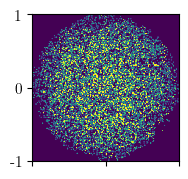

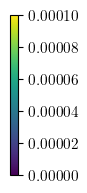

Figure saved to: ../../../mnt/eol/Zacasno/davidsusic/CHF/thesis/PhysioNet_latent_space_01_NoiseInject.png


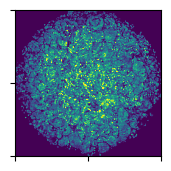

Figure saved to: ../../../mnt/eol/Zacasno/davidsusic/CHF/thesis/PhysioNet_latent_space_01_TimeMask.png


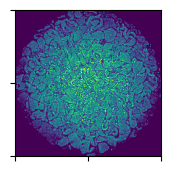

Figure saved to: ../../../mnt/eol/Zacasno/davidsusic/CHF/thesis/PhysioNet_latent_space_01_MagWarp.png


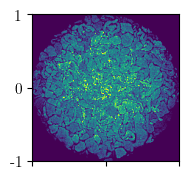

Figure saved to: ../../../mnt/eol/Zacasno/davidsusic/CHF/thesis/PhysioNet_latent_space_01_RespScale.png


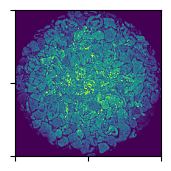

Figure saved to: ../../../mnt/eol/Zacasno/davidsusic/CHF/thesis/PhysioNet_latent_space_01_Mixup.png


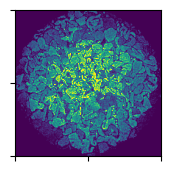

Figure saved to: ../../../mnt/eol/Zacasno/davidsusic/CHF/thesis/PhysioNet_latent_space_01_ManifoldMixup.png


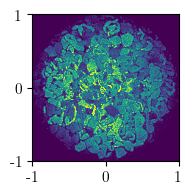

Figure saved to: ../../../mnt/eol/Zacasno/davidsusic/CHF/thesis/PhysioNet_latent_space_01_PCGmix.png


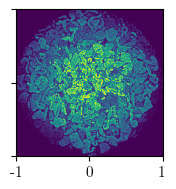

Figure saved to: ../../../mnt/eol/Zacasno/davidsusic/CHF/thesis/PhysioNet_latent_space_01_PCGmix+.png


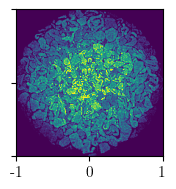

In [128]:
fts_tsne = pd.read_csv(os.path.join(CHF, 'features', f'latent-space_PhysioNet_epoch=50_bs=64_nfrac=0.1_tsne.csv'))
fts_tsne = pd.read_csv(os.path.join(CHF, 'features', f'latent-space_PhysioNet_epoch=50_bs=64_nfrac=0.1_pca.csv'))
fts_tsne = pd.read_csv(os.path.join(CHF, 'features', f'latent-space_PhysioNet_epoch=50_bs=64_nfrac=0.1_pca2-tsne.csv'))
fts_tsne = pd.read_csv(os.path.join(CHF, 'features', f'latent-space_PhysioNet_epoch=50_bs=64_nfrac=0.1_pca2-tsne20.csv'))
for col in ['tsne1', 'tsne2']:
    #fts_tsne[col] = (fts_tsne[col]-fts_tsne[col].mean())/fts_tsne[col].std()
    fts_tsne[col] = (fts_tsne[col]-fts_tsne[col].min())/(fts_tsne[col].max()-fts_tsne[col].min())*2-1
    
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('text.latex', preamble=r'\usepackage{amsmath}')
plt.rc('font', size=11)

methods = [
           'base', 
           'gaussiannoise(25,40)+1.0', 
           'timemask(0.2)+1.0', 
           'magnitudewarp(0.2,4)+1.0', 
           'magnitudewarp(0.2,4)+1.0',#'respiratoryscale(12,20)+1.0',
           'mixup(same)+1.0', 
           'latentmixup',
           'durratiomixup+1.0', 
           'durmixmagwarp(0.2,4)+1.0'
        ]

methods_abbrvs = [
            'Vanilla',
            'NoiseInject',
            'TimeMask',
            'MagWarp',
            'RespScale',
            'Mixup',
            'ManifoldMixup',
            'PCGmix',
            'PCGmix+',
         ]

N = 200

for i, (m, m_abbrv) in enumerate(zip(methods, methods_abbrvs)):
    fts_m = fts_tsne[fts_tsne['method']==m]
    x = fts_m['tsne1'].values
    y = fts_m['tsne2'].values
    heatmap, xedges, yedges = np.histogram2d(x, y, bins=(N, N))
    
    # Normalize to probability density
    heatmap = heatmap/heatmap.sum()
    plt.figure(figsize=(1.9,1.9))
    #im = plt.imshow(heatmap.T, origin='lower', extent=[-1, 1, -1, 1], cmap='viridis')
    im = plt.imshow(heatmap.T, origin='lower', extent=[-1, 1, -1, 1], vmin=0, vmax=0.0001, cmap='viridis')
    #cbar = plt.colorbar(im, shrink=0.8)
    plt.xticks([-1, 0, 1], labels=['', '', ''])
    plt.yticks([-1, 0, 1], labels=['', '', ''])
    if i in [0, 3, 6]:
        plt.yticks([-1, 0, 1], labels=[-1, 0, 1])
    if i in [6, 7, 8]:
        plt.xticks([-1, 0, 1], labels=[-1, 0, 1])
    
    # First save the heatmap
    for extension in ['jpg', 'pdf', 'png']:
        FILENAME = f'PhysioNet_latent_space_01_{m_abbrv}.{extension}'
        FILENAME = os.path.join(RESULTS, FILENAME)
        plt.savefig(FILENAME, dpi=600, bbox_inches='tight')
    print(f'Figure saved to: {FILENAME}')
    plt.show()
    
    if m_abbrv == 'Vanilla':
        # Plot colorbar separately
        fig, ax = plt.subplots(figsize=(2,2))
        cax = plt.axes([0.4, 0.1, 0.04, 0.8])
        cbar = plt.colorbar(im, ax=ax, shrink=0.8, cax=cax)
        ax.remove()
        for extension in ['jpg', 'pdf', 'png']:
            FILENAME=os.path.join(RESULTS, f'PhysioNet_latent_space_01_colorbar.{extension}')
            fig.savefig(FILENAME, dpi=600)  
            #fig.savefig(FILENAME, dpi=600, bbox_inches=bbox)  
    plt.show()
    plt.close()

### Investigating Out-of-manifold Intrusion: Illustrations

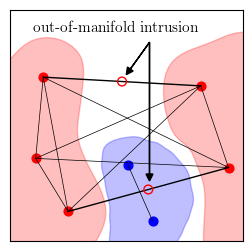

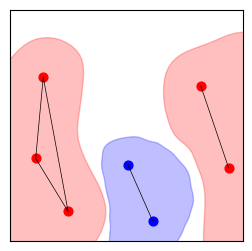

In [5]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('text.latex', preamble=r'\usepackage{amsmath}')
plt.rc('font', size=11)

# Function to create a smooth curve from given points
def smooth_curve(points, num_points=100):
    tck, u = splprep([points[:,0], points[:,1]], s=0, per=True)
    u_new = np.linspace(u.min(), u.max(), num_points)
    x_new, y_new = splev(u_new, tck, der=0)
    return np.stack((x_new, y_new), axis=-1)

x= [0.00689964918236862, 0.0995409664459911, 0.216332824081932, 0.303747241554914, 0.313186074803372, 0.297063316924121, 0.290764867311718, 0.313670570927403, 0.356037458269676, 0.393562920839698, 0.411556470321959, 0.383370819894754, 0.334535732473264, 0.258968482996661, 0.170061676002942, 0.0593525434278277, -0.0208262603972161, -0.0802672155265093, -0.127493209981327, -0.152824930685226, -0.142880382504385, -0.142650512080574, -0.136288406043116, -0.123931986646296, -0.100584224523284, -0.0700079216884513, -0.0236200701635262]
y= [0.79360465116279, 0.869186046511627, 0.87063953488372, 0.797965116279069, 0.677325581395348, 0.550872093023255, 0.462209302325581, 0.376453488372093, 0.289244186046511, 0.212209302325581, 0.107558139534883, 0.0232558139534881, -0.0479651162790697, -0.10610465116279, -0.146802325581395, -0.148255813953488, -0.101744186046511, -0.0319767441860465, 0.0581395348837208, 0.146802325581395, 0.234011627906976, 0.328488372093023, 0.443313953488372, 0.521802325581395, 0.617732558139534, 0.684593023255814, 0.749999999999999]
shape1 = np.array([[a, b] for a, b in zip(x, y)])
smooth_shape1 = smooth_curve(shape1)

x= [0.661100265942398, 0.680759491880269, 0.722238725739829, 0.798973009675776, 0.875686074803372, 0.975531177502404, 1.07281587732699, 1.11527117637073, 1.15407684037797, 1.17949343631528, 1.19875304136253, 1.21912663384824, 1.22978908504498, 1.2319923046455, 1.223274910881, 1.20727946585186, 1.18522251457024, 1.14731864991795, 1.1253076727211, 1.085002546257, 1.04473632094154, 0.994776636677417, 0.929118570701069, 0.881804164544785, 0.850265942398008, 0.832251174107395, 0.83485401459854, 0.838726447122729, 0.830405137780795, 0.800196627624059, 0.77114807899055, 0.716523793357098, 0.683829146155151, 0.669354382391218, 0.657344536864143]
y= [0.670058139534883, 0.749999999999999, 0.797965116279069, 0.835755813953488, 0.864825581395348, 0.901162790697674, 0.885174418604651, 0.834302325581395, 0.783430232558139, 0.729651162790697, 0.645348837209302, 0.518895348837209, 0.401162790697674, 0.306686046511627, 0.223837209302325, 0.149709302325581, 0.0843023255813952, 0.00581395348837188, -0.0406976744186047, -0.10610465116279, -0.155523255813953, -0.188953488372093, -0.174418604651162, -0.120639534883721, -0.0828488372093023, 0.0130813953488371, 0.0828488372093022, 0.174418604651162, 0.254360465116278, 0.338662790697674, 0.399709302325581, 0.449127906976744, 0.511627906976744, 0.562499999999999, 0.626453488372092]
shape2 = np.array([[a, b] for a, b in zip(x, y)])
smooth_shape2 = smooth_curve(shape2)

x= [0.404978639732925, 0.452505233972726, 0.506061506252475, 0.554723306739093, 0.596046936004073, 0.639814264697561, 0.661673173767894, 0.693253833531375, 0.718734085893736, 0.73935876761161, 0.759976376393368, 0.773269959825722, 0.778058337577095, 0.786485740960787, 0.788833955751711, 0.779016720420981, 0.769203021558309, 0.750862898206303, 0.737399564307135, 0.714189724438408, 0.701914643806937, 0.700595541221071, 0.688362898206303, 0.666408504498387, 0.632288660668816, 0.611554348441124, 0.575047388671985, 0.543410145419566, 0.510574039495275, 0.483827731567928, 0.458297968652747, 0.441305239631075, 0.421914785265659, 0.415962909523001, 0.422155265093645, 0.427095710971538, 0.429631358569569, 0.432124568550896, 0.428563345215865, 0.429889520737848, 0.422689271770497, 0.413055932778815, 0.404663894075708, 0.393835228880212, 0.396356730606009, 0.397636932043229]
y= [0.40406976744186, 0.437499999999999, 0.449127906976744, 0.449127906976744, 0.43313953488372, 0.421511627906976, 0.405523255813953, 0.385174418604651, 0.357558139534883, 0.334302325581395, 0.30813953488372, 0.271802325581395, 0.239825581395348, 0.203488372093023, 0.16860465116279, 0.133720930232558, 0.100290697674418, 0.0625, 0.0290697674418602, -0.0101744186046512, -0.0552325581395349, -0.0973837209302326, -0.125, -0.148255813953488, -0.171511627906976, -0.193313953488372, -0.197674418604651, -0.200581395348837, -0.196220930232558, -0.188953488372093, -0.181686046511628, -0.165697674418604, -0.135174418604651, -0.0813953488372092, -0.0363372093023257, -0.0058139534883721, 0.0363372093023255, 0.0610465116279068, 0.0973837209302325, 0.142441860465116, 0.18313953488372, 0.223837209302325, 0.274709302325581, 0.324127906976744, 0.360465116279069, 0.386627906976744]
shape3 = np.array([[a, b] for a, b in zip(x, y)])
smooth_shape3 = smooth_curve(shape3)

# x_red= [0.0796766253607197, 0.0765574605330164, 0.274348582583602, 0.0732084252815028, 0.248362615288858, 0.133190460023765, 0.220382080009053, 0.211328721778984, 0.714497397159508, 0.799280682396876, 0.865741526622531, 0.867828042777117, 0.970675606857918, 0.924934928987721]
# y_red= [0.704941860465116, 0.422965116279069, 0.215116279069767, 0.0465116279069766, 0.0348837209302324, 0.199127906976744, 0.534883720930232, 0.813953488372092, 0.616279069767441, 0.462209302325581, 0.777616279069767, 0.635174418604651, 0.405523255813953, 0.10610465116279]
# x_blue= [0.461997114242064, 0.644475329598823, 0.738952073784869, 0.632737792112261, 0.4968207152153]
# y_blue= [0.338662790697674, 0.337209302325581, 0.167151162790697, 0.0130813953488371, 0.151162790697674]
x_red= [0.142947575397499, 0.110461579811011, 0.249805494256775, 0.82047119900413, 0.93980577717422]
y_red= [0.709302325581395, 0.357558139534883, 0.127906976744185, 0.671511627906976, 0.318023255813953]
x_blue= [0.506988060883834, 0.613453431788604]
y_blue= [0.329941860465116, 0.0872093023255813]


marksize=30
lw=0.7
marksize=40
lw=1

fig = plt.figure(figsize=(3, 3))
# shapes
plt.fill(smooth_shape1[:,0], smooth_shape1[:,1], alpha=0.25, color='r')
plt.fill(smooth_shape2[:,0], smooth_shape2[:,1], alpha=0.25, color='r')
plt.fill(smooth_shape3[:,0], smooth_shape3[:,1], alpha=0.25, color='b')
# points
plt.scatter(x_red, y_red, color='r', s=marksize)
plt.scatter(x_blue, y_blue, color='b', s=marksize)
# connected points
plt.plot([x_red[0], x_red[3]], [y_red[0], y_red[3]], color='k', lw=lw)
plt.scatter(x_red[0]+(x_red[3]-x_red[0])/2, y_red[0]+(y_red[3]-y_red[0])/2, color='r', s=marksize, facecolor='none', zorder=100)
plt.plot([x_red[2], x_red[4]], [y_red[2], y_red[4]], color='k', lw=lw)
plt.scatter(x_red[2]+(x_red[4]-x_red[2])/2, y_red[2]+(y_red[4]-y_red[2])/2, color='r', s=marksize, facecolor='none', zorder=100)

plt.text(0.1, 0.9, r'out-of-manifold intrusion')
plt.arrow(0.6, 0.86, -0.1, -0.14, width=0.0001,length_includes_head=True, head_width=0.03, head_length=0.03, facecolor='k')
plt.arrow(0.6, 0.86, 0, -0.6, width=0.0001,length_includes_head=True, head_width=0.03, head_length=0.03, facecolor='k')

fac = 0.5
plt.plot([x_red[0], x_red[1]], [y_red[0], y_red[1]], color='k', lw=lw*fac)
plt.plot([x_red[0], x_red[2]], [y_red[0], y_red[2]], color='k', lw=lw*fac)
#plt.plot([x_red[0], x_red[3]], [y_red[0], y_red[3]], color='k', lw=lw)
plt.plot([x_red[0], x_red[4]], [y_red[0], y_red[4]], color='k', lw=lw*fac)
plt.plot([x_red[1], x_red[2]], [y_red[1], y_red[2]], color='k', lw=lw*fac)
plt.plot([x_red[1], x_red[3]], [y_red[1], y_red[3]], color='k', lw=lw*fac)
plt.plot([x_red[1], x_red[4]], [y_red[1], y_red[4]], color='k', lw=lw*fac)
plt.plot([x_red[2], x_red[3]], [y_red[2], y_red[3]], color='k', lw=lw*fac)
plt.plot([x_red[3], x_red[4]], [y_red[3], y_red[4]], color='k', lw=lw*fac)
plt.plot([x_blue[0], x_blue[1]], [y_blue[0], y_blue[1]], color='k', lw=lw*fac)

plt.xlim((0, 1))
plt.ylim((0, 1))
plt.xticks([])
plt.yticks([])

for extension in ['jpg', 'pdf', 'png']:
    FILENAME=os.path.join(RESULTS, f'outofmanifold_intrusion_scheme.{extension}')
    plt.savefig(FILENAME, dpi=600, bbox_inches='tight')
plt.show()
plt.close()

fig = plt.figure(figsize=(3, 3))
# shapes
plt.fill(smooth_shape1[:,0], smooth_shape1[:,1], alpha=0.25, color='r')
plt.fill(smooth_shape2[:,0], smooth_shape2[:,1], alpha=0.25, color='r')
plt.fill(smooth_shape3[:,0], smooth_shape3[:,1], alpha=0.25, color='b')
# points
plt.scatter(x_red, y_red, color='r', s=marksize)
plt.scatter(x_blue, y_blue, color='b', s=marksize)
# connected points

plt.plot([x_red[0], x_red[1]], [y_red[0], y_red[1]], color='k', lw=lw*fac)
plt.plot([x_red[0], x_red[2]], [y_red[0], y_red[2]], color='k', lw=lw*fac)
#plt.plot([x_red[0], x_red[3]], [y_red[0], y_red[3]], color='k', lw=lw)
#plt.plot([x_red[0], x_red[4]], [y_red[0], y_red[4]], color='k', lw=lw*fac)
plt.plot([x_red[1], x_red[2]], [y_red[1], y_red[2]], color='k', lw=lw*fac)
#plt.plot([x_red[1], x_red[3]], [y_red[1], y_red[3]], color='k', lw=lw*fac)
#plt.plot([x_red[1], x_red[4]], [y_red[1], y_red[4]], color='k', lw=lw*fac)
#plt.plot([x_red[2], x_red[3]], [y_red[2], y_red[3]], color='k', lw=lw*fac)
#plt.plot([x_red[2], x_red[4]], [y_red[2], y_red[4]], color='k', lw=lw)
plt.plot([x_red[3], x_red[4]], [y_red[3], y_red[4]], color='k', lw=lw*fac)
plt.plot([x_blue[0], x_blue[1]], [y_blue[0], y_blue[1]], color='k', lw=lw*fac)

plt.xlim((0, 1))
plt.ylim((0, 1))
plt.xticks([])
plt.yticks([])

for extension in ['jpg', 'pdf', 'png']:
    FILENAME=os.path.join(RESULTS, f'outofmanifold_intrusion_closest.{extension}')
    plt.savefig(FILENAME, dpi=600, bbox_inches='tight')
plt.show()
plt.close()

### Investigating Out-of-manifold Intrusion: TSP

Mean distance: 0.3638807126071022 ; Total distance: 7.641494964749146 ; Total cost: 21


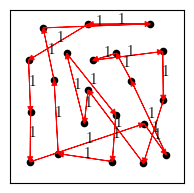

Mean distance: 0.2755131277635999 ; Total distance: 5.785775683035597 ; Total cost: 26


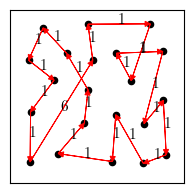

Mean distance: 0.21620157364714654 ; Total distance: 4.540233046590077 ; Total cost: 29


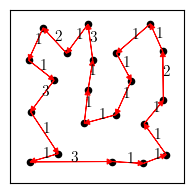

In [108]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('text.latex', preamble=r'\usepackage{amsmath}')
plt.rc('font', size=11)

def distances_to_rankings(distance_matrix, k_num):
    m = distance_matrix.shape[0]
    rankings = np.zeros_like(distance_matrix, dtype=int)
    # Iterate over each row to compute rankings
    for i in range(m):
        sorted_indices = np.argsort(distance_matrix[i])
        # Assign ranks starting from 0 for the closest (self-distance)
        rankings[i, sorted_indices] = np.arange(m)
        # Closest k_num instances (excluding self-distance) get rank 1
        rankings[i, sorted_indices[1:k_num + 1]] = 1
        # Adjust ranks for the rest
        rankings[i, sorted_indices[k_num + 1:]] -= (k_num - 1)
    return rankings

marksize=20
lw=0.7

x = np.array([0.186512712884446, 0.444396599951854, 0.173867639529797, 0.836807521606309, 0.478917531540634, 0.594372696541973, 0.737771117221643, 0.665343785282958, 0.425321339811552, 0.179558685414173])
y = np.array([0.871587830621454, 0.625794661232737, 0.439402313036343, 0.364805026158128, 0.105563221976218, 0.356074348081115, 0.659771408809338, 0.90722255939404, 0.888705045484289, 0.134515167645971])
#x = np.array([0.39654400770334, 0.176202036367088, 0.254347538626893, 0.622878784282745, 0.868348155707829, 0.38980188989513, 0.609011415997314])
#y = np.array([0.147406056208613, 0.36527970380115, 0.835319068139975, 0.873596734217815, 0.385828159912116, 0.585158864435455, 0.433017898737696])
x=np.array([0.106315925095867, 0.190177902399495, 0.118076063701739, 0.252842132387594, 0.324545580920671, 0.276570928706808, 0.586818540908736, 0.425874000210214, 0.447926167283182, 0.606539701699006, 0.764987098939773, 0.895957441758748, 0.879367458135127, 0.768901494217409, 0.876073534348013, 0.695263734289017, 0.474799702987417, 0.447173464163533, 0.610606671933328, 0.80475152320665, 0.115300894767357])
y=np.array([0.709237905044128, 0.89536918053686, 0.411352254888332, 0.593358920718661, 0.74870396050682, 0.169615884070157, 0.123895950660649, 0.344649874379952, 0.537687709578655, 0.393853602633782, 0.112956326266287, 0.163489151920579, 0.476752662432994, 0.342332430315626, 0.759265538064061, 0.591180489392649, 0.708354665572647, 0.916707635867998, 0.749104045948795, 0.918606346440087, 0.121837884022689])

num = len(x)


k_num = 10

for k_num in [12, 6, 2]:

    fts = pd.DataFrame({'x':x, 'y':y})
    pairwise_distances = pdist(fts, metric='euclidean')
    distance_matrix = squareform(pairwise_distances)
    distance_matrix = distances_to_rankings(distance_matrix, k_num)
    # greedy (solves symmetric tsp)
    path = solve_tsp(distance_matrix, endpoints = (0,0))
    # solves asymmetric
    path, _ = solve_tsp_local_search(distance_matrix, x0=path[:-1])
    path.append(path[0])
    indices_label_first=np.array(path[:-1])
    indices_label_second=np.roll(path[:-1], -1)
    
    x_mix = copy.deepcopy(x)
    y_mix = copy.deepcopy(y)
    x_mix[indices_label_first] = x_mix[indices_label_second]
    y_mix[indices_label_first] = y_mix[indices_label_second]

    fig = plt.figure(figsize=(2.25, 2.25))
    plt.scatter(x, y, color='k', s=marksize)
    distances = []
    cost_total = []
    for i in range(num):
        #plt.plot([x[i], x_mix[i]], [y[i], y_mix[i]], color='red', lw=lw)
        plt.arrow(x[i], y[i], x_mix[i]-x[i], y_mix[i]-y[i], color='red', lw=lw, width=0.0001,length_includes_head=True, head_width=0.03, head_length=0.03)
        distance = np.sqrt((x_mix[i]-x[i])**2+(y_mix[i]-y[i])**2)
        idd1 = i
        idd2 = list(x).index(x_mix[i])
        cost = distance_matrix[idd1][idd2]
        distances.append(distance)
        cost_total.append(cost)
        plt.text(x[i]+(x_mix[i]-x[i])/2, y[i]+(y_mix[i]-y[i])/2, s=f'{cost}')

    print('Mean distance:', np.mean(distances), '; Total distance:', np.sum(distances), '; Total cost:', np.sum(cost_total))
    plt.xlim((0, 1))
    plt.ylim((0, 1))
    plt.xticks([])
    plt.yticks([])

    for extension in ['jpg', 'pdf', 'png']:
        FILENAME=os.path.join(RESULTS, f'outofmanifold_intrusion_tspknn{k_num}.{extension}')
        plt.savefig(FILENAME, dpi=600, bbox_inches='tight')
    plt.show()
    plt.close()

### Investigating Out-of-manifold Intrusion: Accuracies

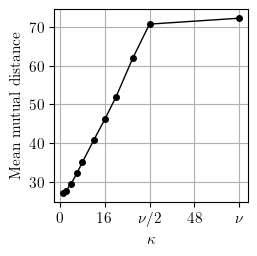

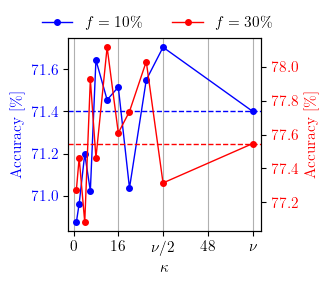

In [39]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('text.latex', preamble=r'\usepackage{amsmath}')
plt.rc('font', size=11)

marksize=4
lw=1

bins_accs_01 = [1, 2, 4, 6, 8, 12, 16, 20, 26, 32, 64]
accs_01 = [70.87545, 70.962992, 71.198682, 71.02359799999999, 71.643126, 71.45457400000001, 71.51517999999999, 71.037066, 71.54885, 71.70373199999999, 71.400702]
bins_distances_01 = [1, 2, 4, 6, 8, 12, 16, 20, 26, 32, 64]
distances_01 = [27.035981468584136, 27.493306712443122, 29.511924346679212, 32.16802646276649, 35.049519860054424, 40.679570862920485, 46.12163341082568, 51.91921200862997, 61.921808451052556, 70.74497549377654, 72.26863884177116]

bins_accs_03 = [1, 2, 4, 6, 8, 12, 16, 20, 26, 32, 64]
accs_03=[77.27275, 77.46214375, 77.08335625000001, 77.92510625, 77.46214375, 78.1145, 77.60945000000001, 77.7357125, 78.030325, 77.31483750000001, 77.54631875000001]
bins_distances_03 = [1, 2, 4, 6, 8, 12, 16, 20, 26, 32, 64]
distances_03 = [27.667729132296966, 28.13112297238845, 30.183808727716254, 32.89830772788766, 35.76578498073559, 41.39255075283557, 46.79895666846763, 52.53517483746158, 62.68255179970023, 71.86763887995536, 72.9483996463729]

fig = plt.figure(figsize=(2.5, 2.5))
plt.plot(bins_distances_01, distances_01, '-o', color='k', markersize=marksize, lw=lw)
plt.scatter(bins_distances_01, distances_01, s=marksize, color='k')
#plt.plot(bins_distances_03, distances_03, color='b', lw=lw)
#plt.scatter(bins_distances_03, distances_03, s=marksize, color='b')

plt.ylabel('Mean mutual distance')
plt.xlabel(r'$\kappa$')
#plt.xlim((0, 34))
plt.xticks((0, 16, 32, 48, 64), [0, 16, r'$\nu/2$', 48, r'$\nu$'])
plt.grid()

for extension in ['jpg', 'pdf', 'png']:
    FILENAME=os.path.join(RESULTS, f'outofmanifold_intrusion_distances.{extension}')
    plt.savefig(FILENAME, dpi=600, bbox_inches='tight')
plt.show()
plt.close()

c1 = '#FF6D31'
c1 = 'b'
c2 = 'r'
fig, ax1 = plt.subplots(figsize=(2.5, 2.5))
# 10%
ax1.plot(bins_accs_01, accs_01, '-o', color=c1, markersize=marksize, lw=lw, label=f'$f=10\%$')
#ax1.scatter(bins_accs_01, accs_01, s=marksize, color=c1)
ax1.axhline(y=accs_01[-1], linestyle='--', lw=lw, color=c1)
# 30%
ax2 = ax1.twinx()
ax2.plot(bins_accs_03, accs_03, '-o', color=c2, markersize=marksize, lw=lw, label=f'$f=30\%$')
#ax2.scatter(bins_accs_03, accs_03, s=marksize, color=c2)
ax2.axhline(y=accs_03[-1], linestyle='--', lw=lw, color=c2)
# fig = plt.figure(figsize=(2.5, 2.5))
# # 10%
# plt.plot(bins_accs_01, accs_01, color=c1, lw=lw)
# plt.scatter(bins_accs_01, accs_01, s=marksize, color=c1)
# plt.axhline(y=accs_01[-1], linestyle='--', lw=lw, color=c1)
# # 30%
# plt.plot(bins_accs_03, accs_03, color=c2, lw=lw)
# plt.scatter(bins_accs_03, accs_03, s=marksize, color=c2)
# plt.axhline(y=accs_03[-1], linestyle='--', lw=lw, color=c2)
# settings
ax1.set_ylabel('Accuracy [\%]', color=c1)
ax1.tick_params(axis='y', labelcolor=c1)
ax2.set_ylabel('Accuracy [\%]', color=c2)
ax2.tick_params(axis='y', labelcolor=c2)
#plt.ylabel('Accuracy [\%]')
plt.xlabel(r'$\kappa$')
ax1.set_xlabel(r'$\kappa$')
plt.xticks((0, 16, 32, 48, 64), [0, 16, r'$\nu/2$', 48, r'$\nu$'])
ax1.grid(axis='x')
#ax2.grid()

legend = fig.legend(ncol=2, bbox_to_anchor=(1.0,1.025), frameon=False, fontsize=11)

for extension in ['jpg', 'pdf', 'png']:
    FILENAME=os.path.join(RESULTS, f'outofmanifold_intrusion_accuracies.{extension}')
    plt.savefig(FILENAME, dpi=600, bbox_inches='tight')
plt.show()
plt.close()

### Saliency Map Visualizations

MVP


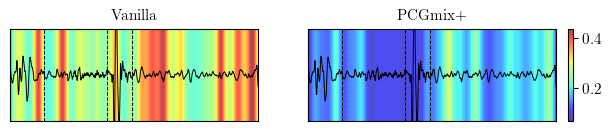

Benign


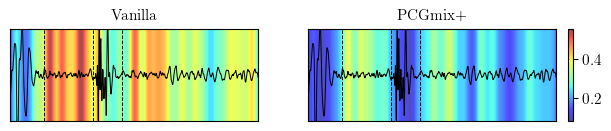

AD


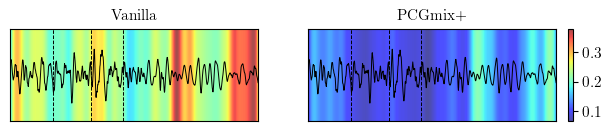

Normal


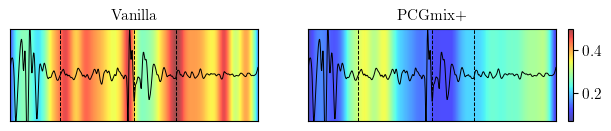

MPC


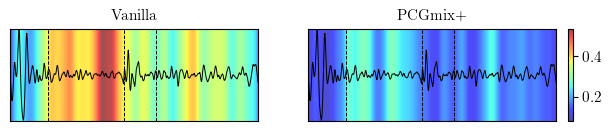

CAD


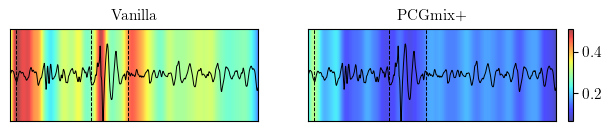

MR


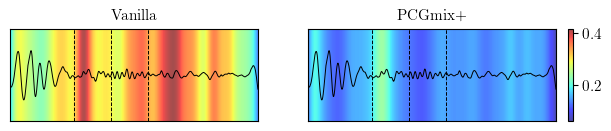

Pathologic


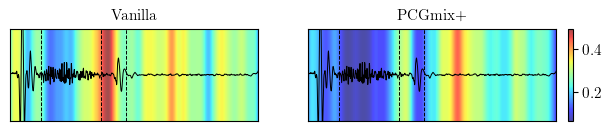

In [167]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('text.latex', preamble=r'\usepackage{amsmath}')
plt.rc('font', size=11)

methods = [
          'base',
#           'gaussiannoise(25,40)',
#           'timemask(0.2)',
#           'respiratoryscale(12,20)',
#           'magnitudewarp(0.2,4)',
#           'latentmixup',
#           'mixup(same)',
#           'durratiomixup',
          'durmixmagwarp(0.2,4)',             
        ]
methods_names = [
          'Vanilla',
#           'Noise injection',
#           'Time masking',
#           'Respiratory scaling',
#           'Magnitude warping',
#           'Manifold Mixuo',
#           'Mixuo',
#           'PCGmix',
          'PCGmix+',             
        ]

lw=0.7

#cvds_unique = ['MVP', 'Benign', 'AD', 'Normal', 'MPC', 'CAD', 'MR', 'AS', 'Pathologic']
cvds_unique = ['MVP', 'Benign', 'AD', 'Normal', 'MPC', 'CAD', 'MR', 'Pathologic']
cvds_ids = ['0_0_MVP', '0_86_Benign', '0_172_AD', '0_198_Normal', '1_250_MPC', '3_6_CAD', '3_749_MR', '4_131_Pathologic']
for cvd_id, cvd in zip(cvds_ids, cvds_unique):
    print(cvd)
    signal = np.loadtxt(os.path.join(RESULTS, 'saliency', f'saliency_{cvd_id}_rawsignal.txt'))
    frames = np.loadtxt(os.path.join(RESULTS, 'saliency', f'saliency_{cvd_id}_frames.txt'))
    length = int(frames[-1])
    # collect all saliency maps to determine the global vmin and vmax
    saliency_maps = []
    for method in methods:
        saliency = np.loadtxt(os.path.join(RESULTS, 'saliency', f'saliency_{cvd_id}_{method}.txt'))
        saliency = saliency[:length]
        saliency_maps.append(saliency)
    global_vmin = min(map(np.min, saliency_maps))
    global_vmax = max(map(np.max, saliency_maps))
    # plot the saliency maps
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(7.5, 1.2))
    for i, (method, method_name) in enumerate(zip(methods, methods_names)):
        saliency = np.loadtxt(os.path.join(RESULTS, 'saliency', f'saliency_{cvd_id}_{method}.txt'))
        saliency = saliency[:length]
        im = axes[i].imshow(saliency.reshape(1, -1), extent=(0, length, -8, 8), cmap='jet', alpha=0.7, aspect='auto', vmin=global_vmin, vmax=global_vmax)
        axes[i].plot(signal[:length], color='k', lw=lw)
        for f in frames:
            axes[i].axvline(x=f, linestyle='--', color='k', lw=lw)
        axes[i].set_ylim((-5, 5))
        axes[i].set_xlim((0, length))
        axes[i].set_xticks([])
        axes[i].set_yticks([])
        axes[i].set_title(method_name, fontsize=11)
    cbar = fig.colorbar(im, ax=axes, orientation='vertical', fraction=0.04, pad=0.02)
    for extension in ['jpg', 'pdf', 'png']:
        FILENAME=os.path.join(RESULTS, f'saliency_{cvd}.{extension}')
        plt.savefig(FILENAME, dpi=600, bbox_inches='tight')
    plt.show()
    plt.close()

### Utilization of Saliency Information: Illustrations

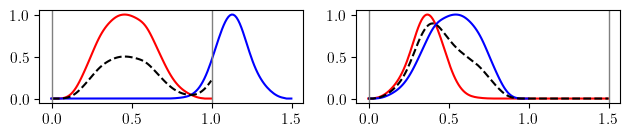

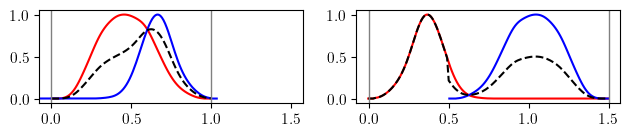

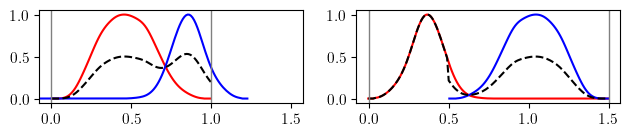

In [18]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('text.latex', preamble=r'\usepackage{amsmath}')
plt.rc('font', size=11)

xs1 = np.array([0.00168598818414894, 0.00842994092074461, 0.0168598818414892, 0.0252898227622339, 0.0354057518671274, 0.043835692787872, 0.0640675509976591, 0.0758694682867016, 0.0961431278564263, 0.108028647865343, 0.123327945602496, 0.135213465611414, 0.148868576524356, 0.159193512428937, 0.166146471965221, 0.172974027421692, 0.18502675287036, 0.197079478319028, 0.210901794671719, 0.222996321480325, 0.233321257384907, 0.245373982833574, 0.257426708282242, 0.266191060082488, 0.278285586891093, 0.288610522795674, 0.300663248244342, 0.312674172333073, 0.32974306097425, 0.348581540519451, 0.362153048712518, 0.377494147809608, 0.391107457362612, 0.406406755099765, 0.421664251476981, 0.43852413331847, 0.455384015159959, 0.477343662913833, 0.494119942035447, 0.509210232972912, 0.536060639839482, 0.552836918961096, 0.572985174451008, 0.587991862668598, 0.601312562702039, 0.611177683647308, 0.621084605952513, 0.629347341433508, 0.637568275554564, 0.64747519785977, 0.657340318805038, 0.669016832014268, 0.677237766135325, 0.68714468844053, 0.697009809385798, 0.706916731691004, 0.71682365399621, 0.728458365845502, 0.746669824991639, 0.754974361832571, 0.768253260506075, 0.779971575075242, 0.794978263292832, 0.804968788317913, 0.81668710288708, 0.841893322929439, 0.856900011147029, 0.882106231189388, 0.893949949838368, 0.910768030319919, 0.929355701705495, 0.947859770371196, 0.964719652212685, 0.978165756325939, 0.996795229071452])
ys1 = np.array([-6.96689332291278e-05, -0.000348344666146527, -0.00069668933229261, -0.00104503399843913, -0.00146304759781523, -0.00181139226396132, -0.00264741946271307, -0.0031351019953183, 0.00429160628692493, 0.0203293947163083, 0.0444905807602276, 0.060528369189611, 0.0930219596477539, 0.133917623453349, 0.174952625125404, 0.191199420354475, 0.240288150707836, 0.289376881061197, 0.354921413443317, 0.412272879277672, 0.453168543083268, 0.502257273436629, 0.55134600378999, 0.617099542971797, 0.674451008806153, 0.715346672611748, 0.764435402965109, 0.805261397837476, 0.845878385910154, 0.902951176011592, 0.918919295507747, 0.95134321703266, 0.975574072009809, 0.999735258053728, 1.01563370861665, 1.01493701928436, 1.01424032995206, 1.02159736930108, 1.00437520900679, 0.987222717645747, 0.961319808271095, 0.944097647976813, 0.926736149816074, 0.893058187493032, 0.859449894103221, 0.809455467617879, 0.767723776613532, 0.734324490023408, 0.69266246795229, 0.650930776947943, 0.600936350462601, 0.575660461487013, 0.533998439415895, 0.492266748411548, 0.442272321926206, 0.400540630921859, 0.358808939917512, 0.325270315460929, 0.258402073347452, 0.233265522238323, 0.191394493367517, 0.174381339872923, 0.140703377549882, 0.115497157507524, 0.0984840040129304, 0.0809134990525022, 0.0472355367294619, 0.0296650317690336, 0.0374400847174225, 0.0284806599041358, 0.0359770371196077, 0.026947943373091, 0.0262512540407984, 0.0174311670939695, 0.0331902797904359])
interpolator = scipy.interpolate.interp1d(xs1, ys1, kind='linear')  # You can use 'linear', 'quadratic', 'cubic', etc.
xs1 = np.linspace(np.min(xs1), np.max(xs1), num=100)
ys1= interpolator(xs1)
ys1[:5] = 0
ys1[-10:] = 0
ys1 = gaussian_filter1d(ys1, 3)
ys1 = ys1 - np.min(ys1)
ys1 = ys1/np.max(ys1)
ys1[:5] = 0
ys1[-5:] = 0

# plt.figure(figsize=(5*0.66, 1))
# plt.plot(xs1, ys1)
# plt.show()
# plt.close()

xs2 = np.array([-0.00303369423058774, 0.875220785524559, 0.899813933420524, 0.919654293688567, 0.936582307495247, 0.950517076327746, 0.96596869227554, 0.973836072646864, 0.981703453018188, 0.984898944274407, 0.992685426132916, 1.00206965361953, 1.01001793250367, 1.0163684657597, 1.02435719390025, 1.03837286124556, 1.04943573287311, 1.06369409575687, 1.07455472110237, 1.08549624496069, 1.09492092170372, 1.11192983402321, 1.12410506020197, 1.14382407270079, 1.15280380762333, 1.16014534766135, 1.17351382690414, 1.18077446842935, 1.18668005986489, 1.19254520204403, 1.2011608936589, 1.21145522941469, 1.21723947308101, 1.22150686963204, 1.22577426618307, 1.23746410128493, 1.24324834495125, 1.25210673210457, 1.25645502716841, 1.26998530343683, 1.28331333342322, 1.29660091415319, 1.31156713902409, 1.3234996696644, 1.33698949667641, 1.35043887443202, 1.36548599781574, 1.3911106017501, 1.42435989051734, 1.45309908719511, 1.49708765353863])
ys2 = np.array([-5.39323418768944e-05, 0.0155594806315475, 0.0693300254830306, 0.089682742998908, 0.129983685466582, 0.176898081356937, 0.223839443418232, 0.270645974624833, 0.317452505831434, 0.344175981231544, 0.377647740909029, 0.424481238286569, 0.484622541022287, 0.53140210605795, 0.598210794558226, 0.658459961977699, 0.73198996858441, 0.832243450591233, 0.872436528375153, 0.92596437768819, 0.979465260830288, 1.03310097482707, 1.03998408995914, 1.04033465018134, 1.0204942899133, 0.980624806180646, 0.934195801367184, 0.880991546105411, 0.854429867730931, 0.821200803591894, 0.741353971442825, 0.688203648522928, 0.641639812854773, 0.59504901101568, 0.548458209176588, 0.475332695133954, 0.4287688594658, 0.388926341904081, 0.355670311594105, 0.335910849838877, 0.282814459260857, 0.223050682918279, 0.189983415804872, 0.156862216349589, 0.130435368829803, 0.0973411355454585, 0.0776086399611681, 0.0513975218088909, 0.0319886202758645, 0.0191662059945789, 0.0199482249517979])
interpolator = scipy.interpolate.interp1d(xs2, ys2, kind='linear')  # You can use 'linear', 'quadratic', 'cubic', etc.
xs2 = np.linspace(np.min(xs2), np.max(xs2), num=150)
ys2= interpolator(xs2)
ys2[:80] = 0
ys2[-10:] = 0
ys2 = gaussian_filter1d(ys2, 4)
ys2 = ys2 - np.min(ys2)
ys2 = ys2/np.max(ys2)
ys2[:30] = 0
ys2[-4:] = 0

# plt.figure(figsize=(5, 1))
# plt.plot(xs2, ys2)
# plt.show()
# plt.close()

y1s = ys2[::-1]
x1s = xs2
# plt.figure(figsize=(5, 1))
# plt.plot(x1s, y1s)
# plt.show()
# plt.close()

y2s = ys1[::-1]
x2s = xs1
# plt.figure(figsize=(5*0.66, 1))
# plt.plot(x2s, y2s)
# plt.show()
# plt.close()


c1 = 'red'
c2 = 'blue'
caug = 'k'
ch = 'grey'
hlw = 1

#print('Default')
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(7.5, 1.2))
axes[0].plot(xs1, ys1, c1, label=r'$s^\text{st}_i$')
axes[0].plot(xs2, ys2, c2, label=r'$s^\text{st}_j$')
aug = ys1*0.5 + ys2[:len(xs1)]*0.5
#print(f'{np.sum(aug)=}')
axes[0].plot(xs1, aug, caug, linestyle='--', label=r'$s^\text{st}_\text{aug}$')
axes[0].axvline(x=0, color=ch, lw=hlw)
axes[0].axvline(x=1, color=ch, lw=hlw)
axes[1].plot(x1s, y1s, c1)
axes[1].plot(x2s, y2s, c2)
aug = y1s*0.5 + np.pad(y2s, (0, len(y1s) - len(y2s)), 'constant')*0.5
#print(f'{np.sum(aug)=}')
axes[1].plot(x1s, aug, caug, linestyle='--')
axes[1].axvline(x=0, color=ch, lw=hlw)
axes[1].axvline(x=1.5, color=ch, lw=hlw)

# save legend separately
legend = axes[0].legend(ncol=3, bbox_to_anchor=(1.02,-0.4), frameon=False, fontsize=11)
fig  = legend.figure
fig.canvas.draw()
bbox  = legend.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
#fig.savefig(filename, dpi="figure", bbox_inches=bbox)
for extension in ['jpg', 'pdf', 'png']:
    FILENAME=os.path.join(RESULTS, f'saliency_util_legend.{extension}')
    fig.savefig(FILENAME, dpi=600, bbox_inches=bbox)  
legend.remove()

for extension in ['jpg', 'pdf', 'png']:
    FILENAME=os.path.join(RESULTS, f'saliency_util_default.{extension}')
    #plt.savefig(FILENAME, dpi=600, bbox_inches='tight')
plt.show()
plt.close()

def optimal_displacement_max_sum(s1, s2, lam):
    len_s1 = len(s1)
    len_s2 = len(s2)
    if len_s1 > len_s2:
        # Zero pad s2 to the length of s1
        s2_padded = np.pad(s2, (0, len_s1 - len_s2), 'constant')
        max_sum = float('-inf')
        opt_displacement = 0
        # Iterate over all possible displacements
        for displacement in range(len_s1 - len_s2 + 1):
            # Create the current shifted version of s2
            current_s2_shifted = np.roll(s2_padded, displacement)
            # Calculate the sum of maximum values at each index
            current_sum = np.sum(s1[:displacement]) + \
                          np.sum(s1[displacement:displacement+len_s2]*lam+current_s2_shifted[displacement:displacement+len_s2]*(1-lam)) + \
                          np.sum(s1[displacement+len_s2:])
#             print(f'{current_sum=}')
#             plt.figure(figsize=(5, 1))
#             plt.plot(s1)
#             plt.plot(current_s2_shifted)
#             plt.show()
#             plt.close()
            if current_sum > max_sum:
                max_sum = current_sum
                opt_displacement = displacement
    else: #len_s1 < len_s2
        # Zero pad s1 to the length of s2
        s1_padded = np.pad(s1, (0, len_s2 - len_s1), 'constant')
        max_sum = float('-inf')
        opt_displacement = 0
        # Iterate over all possible displacements
        for displacement in range(len_s2 - len_s1 + 1):
            # Create the current shifted version of s2
            current_s1_shifted = np.roll(s1_padded, displacement)
            # Calculate the sum of maximum values at each index of the cropped instances
            current_sum = np.sum(current_s1_shifted[displacement:displacement+len_s1]*lam + s2[displacement:displacement+len_s1]*(1-lam))
#             print(f'{current_sum=}')
#             plt.figure(figsize=(5, 1))
#             plt.plot(current_s1_shifted)
#             plt.plot(s2)
#             plt.show()
#             plt.close()
            if current_sum > max_sum:
                max_sum = current_sum
                opt_displacement = displacement
    return opt_displacement

#print('MaxSum')
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(7.5, 1.2))
axes[0].plot(xs1, ys1, c1)
opt_displacement = optimal_displacement_max_sum(ys1, ys2, 0.5)
#print(f'{opt_displacement=}')
step_size = xs2[1] - xs2[0]
shift_amount = opt_displacement * step_size
shifted_xs2 = xs2 - shift_amount
axes[0].plot(shifted_xs2 , ys2, c2)
aug = ys1*0.5 + ys2[opt_displacement:opt_displacement+len(xs1)]*0.5
#print(f'{np.sum(aug)=}')
axes[0].plot(xs1, aug, caug, linestyle='--')
axes[0].axvline(x=0, color=ch, lw=hlw)
axes[0].axvline(x=1, color=ch, lw=hlw)
axes[0].set_xlim(-0.075, 1.575)
axes[1].plot(x1s, y1s, c1)
opt_displacement = optimal_displacement_max_sum(y1s, y2s, 0.5)
#print(f'{opt_displacement=}')
step_size = x2s[1] - x2s[0]
shift_amount = opt_displacement * step_size
shifted_x2s = x2s + shift_amount
axes[1].plot(shifted_x2s , y2s, c2)
#axes[1].plot(x2s, y2s, c2)
aug = list(y1s[:opt_displacement]) + list(y1s[opt_displacement:]*0.5 + y2s*0.5)
#print(f'{np.sum(aug)=}')
axes[1].plot(x1s, aug, caug, linestyle='--')
axes[1].axvline(x=0, color=ch, lw=hlw)
axes[1].axvline(x=1.5, color=ch, lw=hlw)
for extension in ['jpg', 'pdf', 'png']:
    FILENAME=os.path.join(RESULTS, f'saliency_util_maxsum.{extension}')
    #plt.savefig(FILENAME, dpi=600, bbox_inches='tight')
plt.show()
plt.close()

def optimal_displacement_max_envelope(s1, s2, lam):
    len_s1 = len(s1)
    len_s2 = len(s2)
    if len_s1 > len_s2:
        # Zero pad s2 to the length of s1
        s2_padded = np.pad(s2, (0, len_s1 - len_s2), 'constant')
        max_sum = float('-inf')
        opt_displacement = 0
        # Iterate over all possible displacements
        for displacement in range(len_s1 - len_s2 + 1):
            # Create the current shifted version of s2
            current_s2_shifted = np.roll(s2_padded, displacement)
            # Calculate the sum of maximum values at each index
            current_sum = np.sum(s1[:displacement]) + \
                          np.sum(np.maximum(s1[displacement:displacement+len_s2],current_s2_shifted[displacement:displacement+len_s2])) + \
                          np.sum(s1[displacement+len_s2:])
#             print(f'{current_sum=}')
#             plt.figure(figsize=(5, 1))
#             plt.plot(s1)
#             plt.plot(current_s2_shifted)
#             plt.show()
#             plt.close()
            if current_sum > max_sum:
                max_sum = current_sum
                opt_displacement = displacement
    else: #len_s1 < len_s2
        # Zero pad s1 to the length of s2
        s1_padded = np.pad(s1, (0, len_s2 - len_s1), 'constant')
        max_sum = float('-inf')
        opt_displacement = 0
        # Iterate over all possible displacements
        for displacement in range(len_s2 - len_s1 + 1):
            # Create the current shifted version of s2
            current_s1_shifted = np.roll(s1_padded, displacement)
            # Calculate the sum of maximum values at each index of the cropped instances
            current_sum = np.sum(np.maximum(s2[displacement:displacement+len_s1], current_s1_shifted[displacement:displacement+len_s1]))
#             print(f'{current_sum=}')
            if current_sum > max_sum:
                max_sum = current_sum
                opt_displacement = displacement
    return opt_displacement

#print('MaxEnv')
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(7.5, 1.2))
axes[0].plot(xs1, ys1, c1)
opt_displacement = optimal_displacement_max_envelope(ys1, ys2, 0.5)
#print(f'{opt_displacement=}')
step_size = xs2[1] - xs2[0]
shift_amount = opt_displacement * step_size
shifted_xs2 = xs2 - shift_amount
axes[0].plot(shifted_xs2 , ys2, c2)
aug = ys1*0.5 + ys2[opt_displacement:opt_displacement+len(xs1)]*0.5
axes[0].plot(xs1, aug, caug, linestyle='--')
axes[0].axvline(x=0, color=ch, lw=hlw)
axes[0].axvline(x=1, color=ch, lw=hlw)
axes[0].set_xlim(-0.075, 1.575)
axes[1].plot(x1s, y1s, c1)
opt_displacement = optimal_displacement_max_envelope(y1s, y2s, 0.5)
#print(f'{opt_displacement=}')
#print(f'{np.sum(aug)=}')
step_size = x2s[1] - x2s[0]
shift_amount = opt_displacement * step_size
shifted_x2s = x2s + shift_amount
axes[1].plot(shifted_x2s , y2s, c2)
aug = list(y1s[:opt_displacement]) + list(y1s[opt_displacement:]*0.5 + y2s*0.5)
axes[1].plot(x1s, aug, caug, linestyle='--')
axes[1].axvline(x=0, color=ch, lw=hlw)
axes[1].axvline(x=1.5, color=ch, lw=hlw)
#print(f'{np.sum(aug)=}')
for extension in ['jpg', 'pdf', 'png']:
    FILENAME=os.path.join(RESULTS, f'saliency_util_maxenv.{extension}')
    plt.savefig(FILENAME, dpi=600, bbox_inches='tight')
plt.show()
plt.close()

### Utilization of Saliency Information: Results

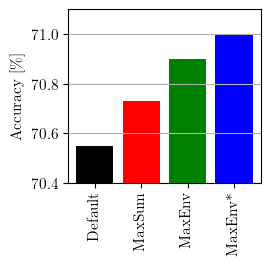

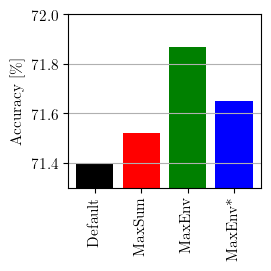

In [202]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('text.latex', preamble=r'\usepackage{amsmath}')
plt.rc('font', size=11)

colors = ['k', 'red', 'green', 'blue']
x = [0, 1, 2, 3]
methods = ['Default', 'MaxSum', 'MaxEnv', 'MaxEnv*']

# PCGmix: default, saloptsum, saloptenv, saloptenv-1
accs = [70.55, 70.73, 70.90, 71.00]
stds = [2.88, 2.65, 2.80, 2.94]

fig = plt.figure(figsize=(2.5, 2.25))
plt.bar(x, accs, align='center', color = colors)
plt.xticks(x, labels=methods, rotation=90)
plt.ylim(bottom=70.4, top = 71.1)
plt.grid(axis='y')
plt.ylabel('Accuracy [\%]')

for extension in ['jpg', 'pdf', 'png']:
    FILENAME=os.path.join(RESULTS, f'saliency_util_PCGmix.{extension}')
    plt.savefig(FILENAME, dpi=600, bbox_inches='tight')
plt.show()
plt.close()

# PCGmix+: default, saloptsum, saloptenv, saloptenv-2
accs = [71.40, 71.52, 71.87, 71.65]
stds = [2.59, 2.79, 2.70, 2.71]

fig = plt.figure(figsize=(2.5, 2.25))
plt.bar(x, accs, align='center', color = colors)
plt.xticks(x, labels=methods, rotation=90)
plt.ylim(bottom=71.3, top = 72)
plt.grid(axis='y')
plt.ylabel('Accuracy [\%]')

for extension in ['jpg', 'pdf', 'png']:
    FILENAME=os.path.join(RESULTS, f'saliency_util_PCGmix+.{extension}')
    plt.savefig(FILENAME, dpi=600, bbox_inches='tight')
plt.show()
plt.close()

### Data Augmentaion: UMLJ Experiments

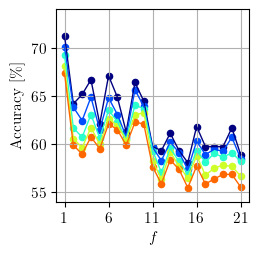

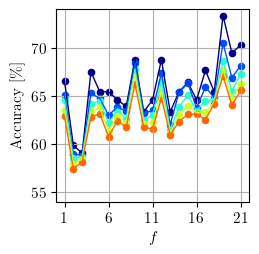

In [147]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('text.latex', preamble=r'\usepackage{amsmath}')
plt.rc('font', size=11)

acc_1=[0.7125, 0.64167, 0.65139, 0.66667, 0.62083, 0.67083, 0.64861, 0.6125, 0.66389, 0.64444, 0.59722, 0.59306, 0.61111, 0.59306, 0.58056, 0.61806, 0.59722, 0.59722, 0.59722, 0.61667, 0.58889]
acc_2=[0.7006950000000001, 0.638195, 0.624305, 0.6486149999999999, 0.61458, 0.647915, 0.630555, 0.60764, 0.65625, 0.6388849999999999, 0.596525, 0.58264, 0.602085, 0.590975, 0.573615, 0.6027800000000001, 0.5888899999999999, 0.594445, 0.59236, 0.6069450000000001, 0.5847249999999999]
acc_3=[0.69213, 0.6166666666666666, 0.6069433333333333, 0.6305566666666667, 0.6060166666666666, 0.6351833333333333, 0.6231466666666666, 0.6050933333333334, 0.6402766666666667, 0.63657, 0.5930533333333333, 0.57037, 0.59537, 0.5819466666666667, 0.5689833333333333, 0.5930566666666667, 0.58102, 0.5902766666666667, 0.58611, 0.59074, 0.5819466666666666]
acc_4=[0.6809025, 0.605555, 0.5961799999999999, 0.617015, 0.5996524999999999, 0.6263875, 0.619095, 0.60382, 0.62986, 0.632635, 0.5826375, 0.563195, 0.5916675, 0.5770850000000001, 0.564585, 0.5878475000000001, 0.5673625, 0.5750000000000001, 0.5777775, 0.576735, 0.5666675]
acc_5=[0.673334, 0.59861, 0.589444, 0.607224, 0.595, 0.6208319999999999, 0.6147199999999999, 0.5986119999999999, 0.6224999999999999, 0.62083, 0.5761100000000001, 0.558612, 0.583334, 0.573612, 0.554446, 0.576944, 0.558334, 0.563612, 0.568334, 0.5683320000000001, 0.555278]
x=[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0]
x = [x+1 for x in x]

lw = 1
marksize = 20
colors = plt.cm.jet(np.linspace(0,1,6))

accs = [acc_1, acc_2, acc_3, acc_4, acc_5]

fig = plt.figure(figsize=(2.5, 2.5))
for i, acc in enumerate(accs):
    acc = [x*100 for x in acc]
    plt.plot(x, acc, color=colors[i], lw=lw)
    plt.scatter(x, acc, s=marksize, color=colors[i], label=f'Top {i+1}')

plt.xlabel(fr'$f$')
plt.ylabel(r'Accuracy [\%]')
plt.xlim((0, 22))
plt.ylim((54, 74))
plt.xticks([1, 6, 11, 16, 21])
plt.grid()

# save legend separately
legend = plt.legend(ncol=5, bbox_to_anchor=(1,1.4), frameon=False, fontsize=11)
fig  = legend.figure
fig.canvas.draw()
bbox  = legend.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
#fig.savefig(filename, dpi="figure", bbox_inches=bbox)
for extension in ['jpg', 'pdf', 'png']:
    FILENAME=os.path.join(RESULTS, f'aug_UMCL_legend.{extension}')
    fig.savefig(FILENAME, dpi=600, bbox_inches=bbox)  
legend.remove()

for extension in ['jpg', 'pdf', 'png']:
    FILENAME=os.path.join(RESULTS, f'aug_UMCL_params1.{extension}')
    plt.savefig(FILENAME, dpi=600, bbox_inches='tight')
plt.show()
plt.close()

acc_1=[0.66528, 0.59861, 0.59028, 0.675, 0.65417, 0.65417, 0.64583, 0.63889, 0.6875, 0.63333, 0.64583, 0.6875, 0.63333, 0.65417, 0.66389, 0.64583, 0.67639, 0.65417, 0.73333, 0.69444, 0.70278]
acc_2=[0.650695, 0.589585, 0.588195, 0.65278, 0.6472249999999999, 0.629865, 0.6381950000000001, 0.63403, 0.68403, 0.631945, 0.63472, 0.67361, 0.620135, 0.653475, 0.663195, 0.6375, 0.65903, 0.64792, 0.70486, 0.66875, 0.6812499999999999]
acc_3=[0.64537, 0.5851866666666666, 0.5865733333333334, 0.6412066666666667, 0.64491, 0.6213000000000001, 0.6351866666666667, 0.62639, 0.6773166666666667, 0.625, 0.6300899999999999, 0.6643500000000001, 0.6148133333333333, 0.6384266666666667, 0.6509266666666667, 0.6342599999999999, 0.64491, 0.6453733333333334, 0.6865733333333334, 0.6550933333333333, 0.6722233333333333]
acc_4=[0.63507, 0.5791675000000001, 0.5840275, 0.6336825, 0.63785, 0.6131975000000001, 0.629515, 0.621875, 0.6729175000000001, 0.620485, 0.6225674999999999, 0.6541650000000001, 0.6114575, 0.63021, 0.639585, 0.6322924999999999, 0.63264, 0.643405, 0.6770825, 0.64757, 0.6625]
acc_5=[0.6286120000000001, 0.5738900000000001, 0.581666, 0.628058, 0.6313920000000001, 0.607502, 0.6238900000000001, 0.6172219999999999, 0.6622220000000001, 0.6172219999999999, 0.6155539999999999, 0.647498, 0.609444, 0.623056, 0.6308339999999999, 0.6311119999999999, 0.625278, 0.641946, 0.670554, 0.640278, 0.655556]
x=[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0]
x = [x+1 for x in x]

accs = [acc_1, acc_2, acc_3, acc_4, acc_5]

fig = plt.figure(figsize=(2.5, 2.5))
for i, acc in enumerate(accs):
    acc = [x*100 for x in acc]
    plt.plot(x, acc, color=colors[i], lw=lw)
    plt.scatter(x, acc, s=marksize, color=colors[i], label=f'Top {i+1}')

plt.xlabel(fr'$f$')
plt.ylabel(r'Accuracy [\%]')
plt.xlim((0, 22))
plt.ylim((54, 74))
plt.xticks([1, 6, 11, 16, 21])
plt.grid()

for extension in ['jpg', 'pdf', 'png']:
    FILENAME=os.path.join(RESULTS, f'aug_UMCL_params2.{extension}')
    plt.savefig(FILENAME, dpi=600, bbox_inches='tight')
plt.show()
plt.close()